# Function Definition

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, math
import warnings
warnings.filterwarnings("ignore")

def get_res_df_single_round(reports_path):
    '''
    Return both performance and resource monitoring dataframes. 
    '''
    df_ls1, df_ls2 = [], []
    file_list = sorted(os.listdir(reports_path))
    file_list = [file for file in file_list if 'report' in file and '.html' in file]
    for file in file_list:
        df_ls = pd.read_html(os.path.join(reports_path, file), flavor='bs4')
        # calculate resources
        df_resource = df_ls[2]
        # df_resource = df_resource.drop(labels = df_resource.columns[4:8], axis=1)
        if 'Memory(max) [MB]' in df_resource.columns:
            cols = []
            for col in df_resource.columns:
                if 'MB' in col:
                    col = col.replace('MB', 'GB')
                cols.append(col)
            df_resource.columns = cols
            df_resource[cols[3:5]] = df_resource[cols[3:5]]/1000
        # calculate performance
        df_perf=df_ls[0]
        rates = int(file.split('-')[1])
        df_perf['Rate'] = rates
        df_resource['Rate'] = rates
        
        df_ls1.append(df_perf)
        df_ls2.append(df_resource)
    df1 = pd.concat(df_ls1)
    df2 = pd.concat(df_ls2)
    return df1, df2

def get_res_df_multi_rounds(reports_path):
    '''
    Input: the path for all 5+ rounds of reports
    Output: dataframes with all collected data for both performance and resources
    '''
    reports_folders = os.listdir(reports_path)
    network_size = int(reports_path.split('/')[-1].split('_')[0])
    paths = []
    df_ls_perf, df_ls_resource = [], []
    for folder in reports_folders:
        curr_reports_path = reports_path+'/'+folder
        reports = [file for file in os.listdir(curr_reports_path) if 'report' in file and '.html' in file]
        print('{} has {} reports.'.format(folder, len(reports)))
        df_perf, df_resource = get_res_df_single_round(curr_reports_path)
        # print('{} has {} nodes resources monitored!'.format(folder, len(df_resource.index.unique())))
        if len(df_resource.index.unique()) == network_size:
            df_ls_perf.append(df_perf)
            df_ls_resource.append(df_resource)
            # if len(df_ls_perf) == 5:
                # break
    print(len(df_ls_perf), 'rounds of reports are collected!')
    # if len(df_ls_perf) < 5:
    #     print("Not enough rounds data are collected!")
    #     return
    df1 = pd.concat(df_ls_perf)
    df2 = pd.concat(df_ls_resource)
    return df1, df2

def plot_perf(df_resource: pd.DataFrame, withArrivalRate=False):
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_resource[df_resource.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_resource[df_resource.index == roundLabels[0]]['Rate'].values
    rows, cols = 1, 2
    fig, axes = plt.subplots(figsize=(16,5), ncols=cols, nrows=rows)
    axes[0].plot(rates, data[0][0], label='open', marker='*', color='C0')
    axes[0].plot(rates, data[0][1], label='query', marker='d', color='C1')
    axes[0].plot(rates, data[0][2], label='transfer', marker='<', color='C2')
    if withArrivalRate:
        axes[0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='C0')
        axes[0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='C1')
        axes[0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='C2')
    axes[0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(rates, data[1][0], label='open', marker='*')
    axes[1].plot(rates, data[1][1], label='query', marker='d')
    axes[1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1].grid()
    axes[1].legend()

def plot_resource(df_resource, jvm_max_heap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        # Y1 = df_node[metrics[2]].values
        # axes[0].plot(X, Y1, '--', marker='*', label=node+' '+metrics[2])
        Y2 = df_node[metrics[3]].values
        axes[0].plot(X, Y2, marker='d', label=node)
        
        # Y3 = df_node[metrics[0]].values
        # axes[1].plot(X, Y3, '--', marker='*', label=node+' '+metrics[0])
        Y4 = df_node[metrics[1]].values
        axes[1].plot(X, Y4, marker='d', label=node)
        
    axes[0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node' + ' '+metrics[3])
    axes[0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[1].grid()
    axes[1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    plt.show()

def plot_all(df_perf, df_resource, jvm_max_heap, withArrivalRate=False):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    ## plot resources
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        Y2 = df_node[metrics[3]].values
        axes[0][0].plot(X, Y2, marker='d', label=node)
        Y4 = df_node[metrics[1]].values
        axes[0][1].plot(X, Y4, marker='d', label=node)
    axes[0][0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node'+' '+metrics[3])
    axes[0][0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0][0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0][0].legend(loc='upper left', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[0][1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[0][1].grid()
    axes[0][1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    
    ## plot perforamnce
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_perf[df_perf.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_perf[df_perf.index == roundLabels[0]]['Rate'].values
    axes[1][0].plot(rates, data[0][0], label='open', marker='*', color='C0')
    axes[1][0].plot(rates, data[0][1], label='query', marker='d', color='C1')
    axes[1][0].plot(rates, data[0][2], label='transfer', marker='<', color='C2')
    if withArrivalRate:
        axes[1][0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='C0')
        axes[1][0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='C1')
        axes[1][0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='C2')
    axes[1][0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[1][0].grid()
    axes[1][0].legend()

    axes[1][1].plot(rates, data[1][0], label='open', marker='*')
    axes[1][1].plot(rates, data[1][1], label='query', marker='d')
    axes[1][1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1][1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1][1].grid()
    axes[1][1].legend()
    plt.tight_layout()
    plt.show()

def cal_mean(df):
    ''' 
    Calculate mean value grouping by rate for all three rounds or different nodes
    '''
    rates = sorted(df.Rate.unique())
    df_ls = []
    for rate in rates:
        df_mean = df[df.Rate == rate].groupby('Name').mean().round(2)
        df_ls.append(df_mean)
    return pd.concat(df_ls)


def plot(reports_path, jvm_max_heap=1.82, all_in_one=True):
    '''
    jvm_max_heap = 7.28 * 0.8 = 5.83 or 7.28 * 0.25 = 1.82
    '''
    f = reports_path.split('/')[-1]
    if '2022' in f:
        df_perf, df_res = get_res_df_single_round(reports_path)
    else:
        df_perf, df_res = get_res_df_multi_rounds(reports_path)

    df_perf_mean, df_res_mean = cal_mean(df_perf), cal_mean(df_res)
    df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]

    if all_in_one:
        plot_all(df_perf_mean, df_res_mean, jvm_max_heap, False)
    else:
        plot_perf(df_res_mean)
        plot_resource(df_res_mean, jvm_max_heap)
        
def plot_perf_merge(reports_path):
    df_perf, df_res = get_res_df_multi_rounds(reports_path)
    df = cal_mean(df_perf)
    # df_res_mean = cal_mean(df_res)
    # df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]
    roundLabels = ['open', 'transfer', 'query']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df[df.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df[df.index == roundLabels[0]]['Rate'].values.astype(int)
    width = 0.2
    X_axis = np.arange(1, len(rates)+1)
    
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax1.bar(X_axis - width, data[0][0], width=width, label='open', color='C0')
    ax1.bar(X_axis, data[0][1], width=width, label='transfer', color='C1')
    ax1.bar(X_axis + width, data[0][2], width=width, label='query', color='C2')
    ax1.set(ylabel='Average Throughput (TPS)')
    ax1.set_xlabel('Transaction Send Rate (req/s)')
    ax1.grid()

    ax2 = ax1.twinx()

    ax2.plot(X_axis, data[1][0], label='open', marker='<', color='C0')
    ax2.plot(X_axis, data[1][1], label='transfer', marker='d', color='C1')
    ax2.plot(X_axis, data[1][2], label='query', marker='*', color='C2', linewidth=2)
    ax2.set(title='Besu Performance under Varying Send Rates', ylabel='Average Latency (S)')
    ax2.set_ylim(0, 2.1)
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Create custom legend by unpacking tuples containing handles and using 
    # only one set of unpacked labels along with set of unpacked empty strings
    # (using None instead of empty strings gives the same result)
    ax1.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
                 loc='upper left', ncol=2, handlelength=3, edgecolor='black',
                 borderpad=0.7, handletextpad=1.5, columnspacing=0)
    plt.xticks(X_axis, rates)

20220413-005733 has 50 reports.
20220413-033946 has 50 reports.
20220413-024540 has 50 reports.
20220413-015132 has 50 reports.
20220413-043343 has 50 reports.


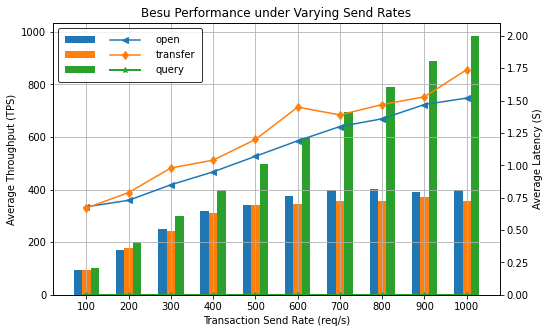

In [104]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/4_LB_2C7.5G_QBFT_1S')

20220413-072032 has 50 reports.
20220413-081436 has 50 reports.
20220413-062628 has 50 reports.
20220413-090853 has 50 reports.
20220413-053204 has 50 reports.


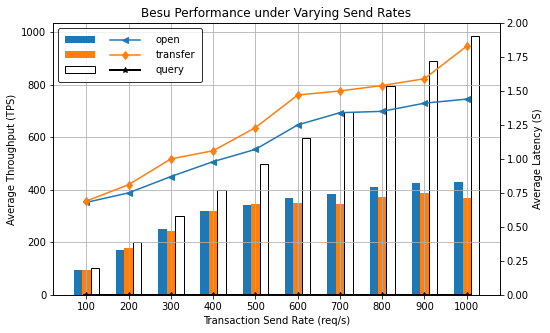

In [89]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/6_LB_2C7.5G_QBFT_1S')

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.


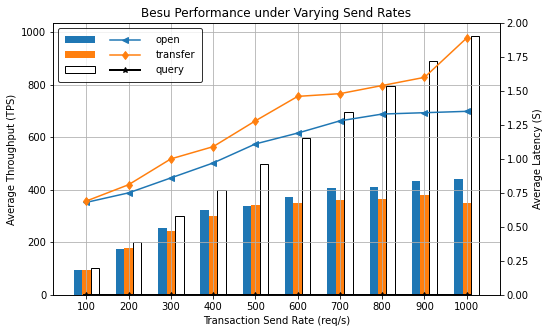

In [88]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')

20220413-115517 has 50 reports.
20220413-110110 has 50 reports.
20220413-134348 has 50 reports.
20220413-100708 has 50 reports.
20220413-124930 has 50 reports.


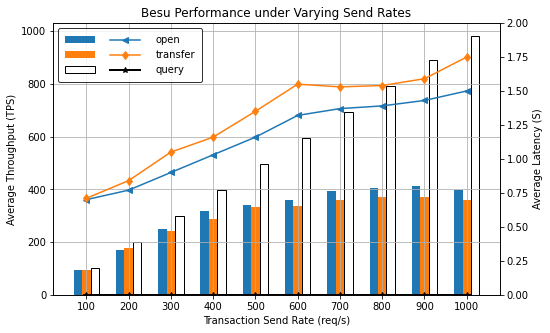

In [90]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/10_LB_2C7.5G_QBFT_1S')

20220413-182005 has 50 reports.
20220413-144224 has 50 reports.
20220413-153657 has 50 reports.
20220413-163129 has 50 reports.
20220413-172545 has 50 reports.


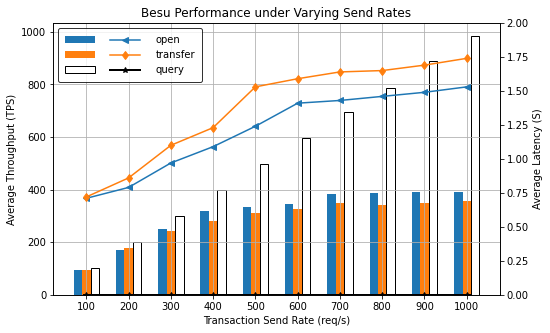

In [92]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/12_LB_2C7.5G_QBFT_1S')

20220413-210837 has 50 reports.
20220413-191908 has 50 reports.
20220413-225752 has 50 reports.
20220413-201403 has 50 reports.
20220413-220321 has 50 reports.


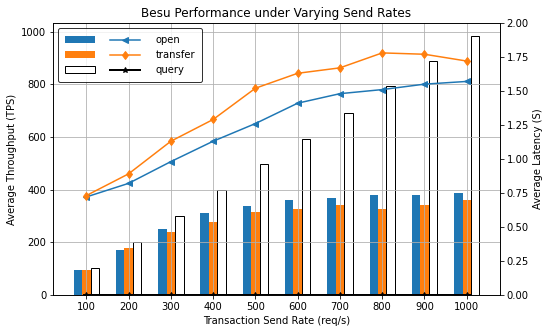

In [93]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/14_LB_2C7.5G_QBFT_1S')

20220414-015008 has 50 reports.
20220414-005444 has 50 reports.
20220414-034128 has 50 reports.
20220413-235907 has 50 reports.
20220414-024548 has 50 reports.


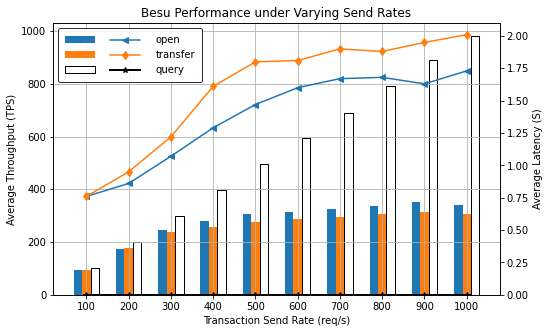

In [100]:
plot_perf_merge(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/16_LB_2C7.5G_QBFT_1S')

# Scale-out

In [27]:
# sendrate = 1000
roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

netsizes = [4,6,8,10,12,14,16,20,24,32]
# netsizes = [28]
sendrate = 1000
for n in netsizes:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/{}_LB_2C7.5G_QBFT_1S'.format(n)
    df, _ = get_res_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

20220413-005733 has 50 reports.
20220413-033946 has 50 reports.
20220413-024540 has 50 reports.
20220413-015132 has 50 reports.
20220413-043343 has 50 reports.
5 rounds of reports are collected!
20220413-072032 has 50 reports.
20220413-081436 has 50 reports.
20220413-062628 has 50 reports.
20220413-090853 has 50 reports.
20220413-053204 has 50 reports.
5 rounds of reports are collected!
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220413-115517 has 50 reports.
20220413-110110 has 50 reports.
20220413-134348 has 50 reports.
20220413-100708 has 50 reports.
20220413-124930 has 50 reports.
5 rounds of reports are collected!
20220413-182005 has 50 reports.
20220413-144224 has 50 reports.
20220413-153657 has 50 reports.
20220413-163129 has 50 reports.
20220413-172545 has 50 reports.
5 rounds of reports are collected!
20220413-210837 has 50 re

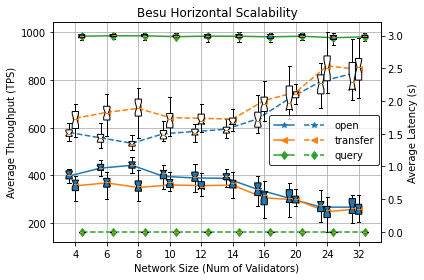

In [28]:
open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]

fig, ax1 = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
xlabels = netsizes
positions = np.arange(1, len(netsizes)+1)
width = 0.2
widths = tuple([0.2] * len(netsizes))

ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans,  patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions-width, open_tps_mean, color='C0', marker='*', label='open')
ax1.plot(positions, transfer_tps_mean, color='C1', marker='<', label='transfer')
ax1.plot(positions+width, query_tps_mean, color='C2', marker='d', label='query')
ax1.grid()

ax1.set_title("Besu Horizontal Scalability")
ax1.set_xlabel('Network Size (Num of Validators)')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='<', label='transfer')
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="w"), showmeans=showmeans)
ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.set_xticks(positions)
ax2.set_xticklabels(netsizes)
# Create custom legend by unpacking tuples containing handles and using 
# only one set of unpacked labels along with set of unpacked empty strings
# (using None instead of empty strings gives the same result)
ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
             loc=(0.66,0.35), ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)

plt.tight_layout()
plt.show()

# fig.set_size_inches(6, 4)
# fig.savefig('./figs/scaleout.png', dpi=300)

20220413-005733 has 50 reports.
20220413-033946 has 50 reports.
20220413-024540 has 50 reports.
20220413-015132 has 50 reports.
20220413-043343 has 50 reports.


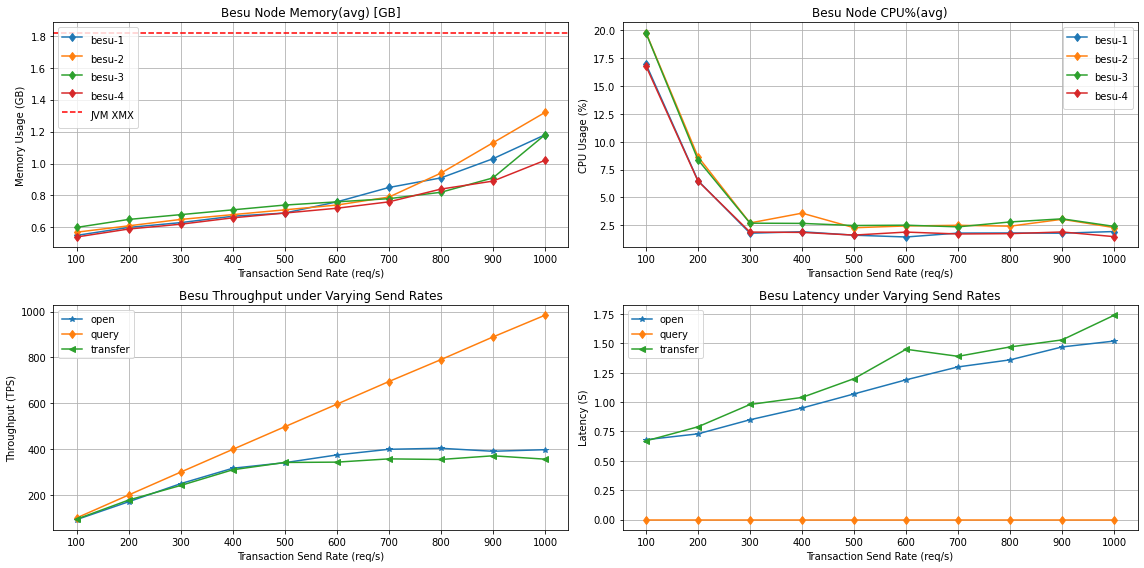

In [2]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/4_LB_2C7.5G_QBFT_1S')

20220413-072032 has 50 reports.
20220413-081436 has 50 reports.
20220413-062628 has 50 reports.
20220413-090853 has 50 reports.
20220413-053204 has 50 reports.


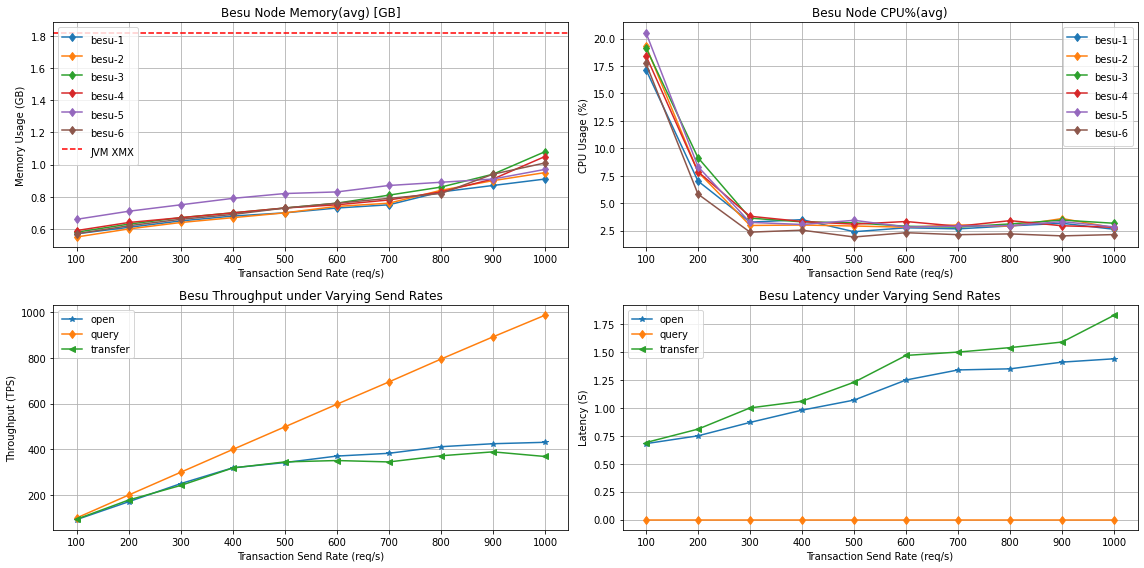

In [4]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/6_LB_2C7.5G_QBFT_1S')

20220411-233402 has 50 reports.
20220411-214147 has 50 reports.
20220411-223857 has 50 reports.
20220411-204628 has 50 reports.
20220412-003103 has 50 reports.


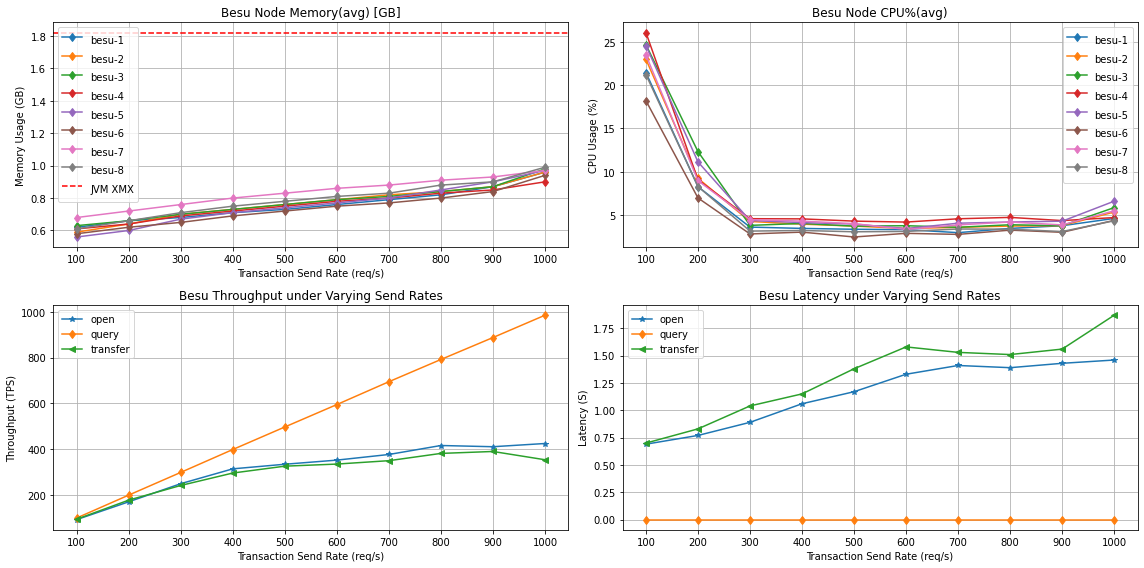

In [3]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')

20220413-115517 has 50 reports.
20220413-110110 has 50 reports.
20220413-134348 has 50 reports.
20220413-100708 has 50 reports.
20220413-124930 has 50 reports.


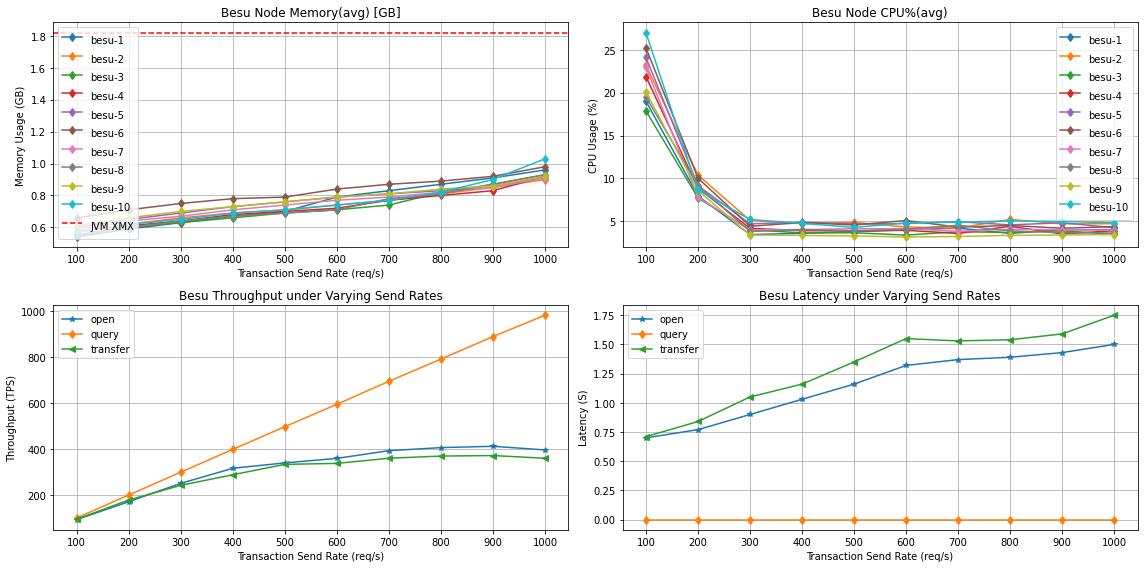

In [5]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/10_LB_2C7.5G_QBFT_1S')

20220413-182005 has 50 reports.
20220413-144224 has 50 reports.
20220413-153657 has 50 reports.
20220413-163129 has 50 reports.
20220413-172545 has 50 reports.


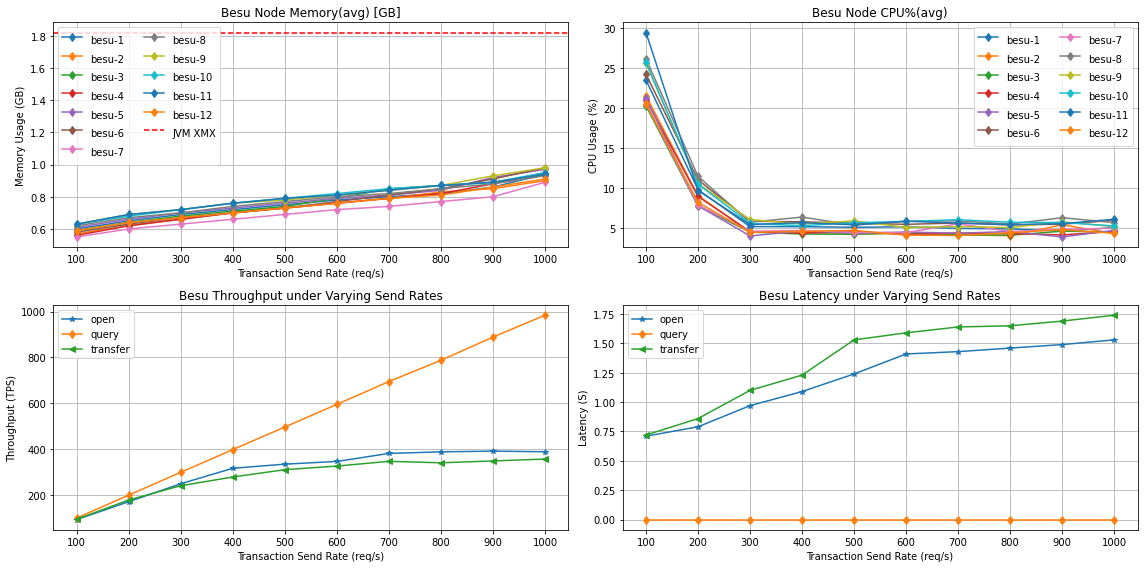

In [6]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/12_LB_2C7.5G_QBFT_1S')

20220413-210837 has 50 reports.
20220413-191908 has 50 reports.
20220413-225752 has 50 reports.
20220413-201403 has 50 reports.
20220413-220321 has 50 reports.


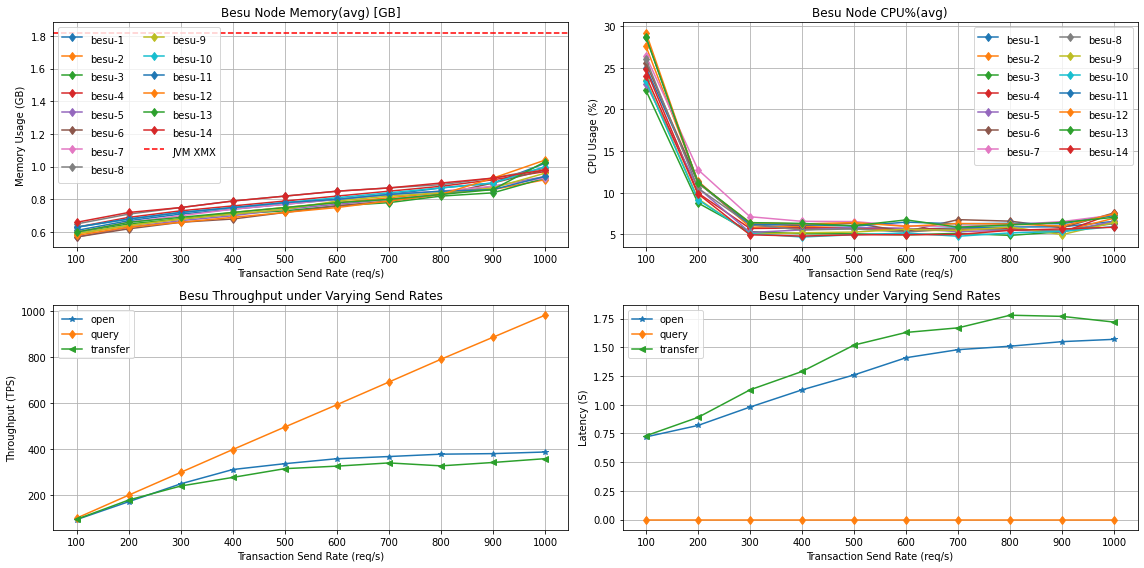

In [7]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/14_LB_2C7.5G_QBFT_1S')

20220414-015008 has 50 reports.
20220414-005444 has 50 reports.
20220414-034128 has 50 reports.
20220413-235907 has 50 reports.
20220414-024548 has 50 reports.


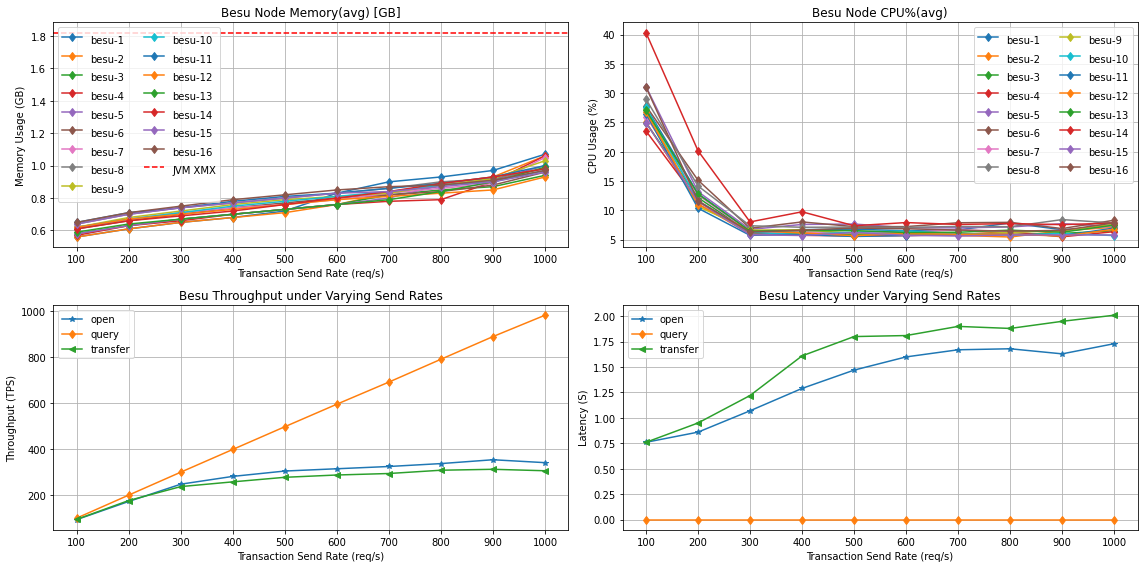

In [8]:
plot(reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/16_LB_2C7.5G_QBFT_1S')

# Scale-up 

In [415]:
# sendrate = 1000
roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
sendrate = 1000
for fl in flavors:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_{}_QBFT_1S'.format(fl)
    df, _ = get_res_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

20220414-185939 has 50 reports.
20220414-224402 has 50 reports.
20220414-214821 has 50 reports.
20220414-205243 has 50 reports.
20220414-195715 has 50 reports.
5 rounds of reports are collected!
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220421-222310 has 50 reports.
20220421-212903 has 50 reports.
20220421-194057 has 50 reports.
20220421-203503 has 50 reports.
20220421-184628 has 50 reports.
5 rounds of reports are collected!
20220414-072413 has 50 reports.
20220414-044206 has 50 reports.
20220414-053605 has 50 reports.
20220414-081809 has 50 reports.
20220414-063006 has 50 reports.
5 rounds of reports are collected!
20220415-132547 has 50 reports.
20220415-113806 has 50 reports.
20220415-104402 has 50 reports.
20220415-141952 has 50 reports.
20220415-123154 has 50 reports.
5 rounds of reports are collected!
20220415-075710 has 50 re

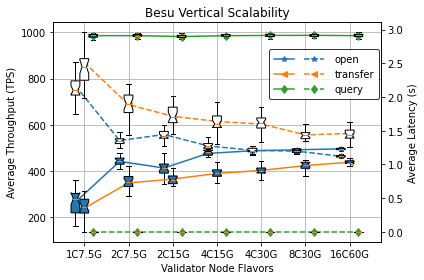

In [419]:
import statistics as st

open_lat_mean, open_tps_mean = [st.mean(lat) for lat in open_lat], [st.mean(tps) for tps in open_tps]
transfer_lat_mean, transfer_tps_mean = [st.mean(lat) for lat in transfer_lat], [st.mean(tps) for tps in transfer_tps]
query_lat_mean, query_tps_mean = [st.mean(lat) for lat in query_lat], [st.mean(tps) for tps in query_tps]

fig, ax1 = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
xlabels = flavors
positions = np.arange(1, len(flavors)+1)
width = 0.2
widths = tuple([0.2] * len(flavors))

ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions-width, open_tps_mean, color='C0', marker='*', label='open')
ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions, transfer_tps_mean, color='C1', marker='<', label='transfer')
ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions+width, query_tps_mean, color='C2', marker='d', label='query')
ax1.grid()

ax1.set_title("Besu Vertical Scalability")
ax1.set_xlabel('Validator Node Flavors')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='<', label='transfer')
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="w"), showmeans=showmeans)
ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.set_xticks(positions)
ax2.set_xticklabels(flavors)
# Create custom legend by unpacking tuples containing handles and using 
# only one set of unpacked labels along with set of unpacked empty strings
# (using None instead of empty strings gives the same result)
ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
             loc=(0.66,0.65), ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)

plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('scaleup.png', dpi=300)

1C7.5G
20220414-185939 has 50 reports.
20220414-224402 has 50 reports.
20220414-214821 has 50 reports.
20220414-205243 has 50 reports.
20220414-195715 has 50 reports.


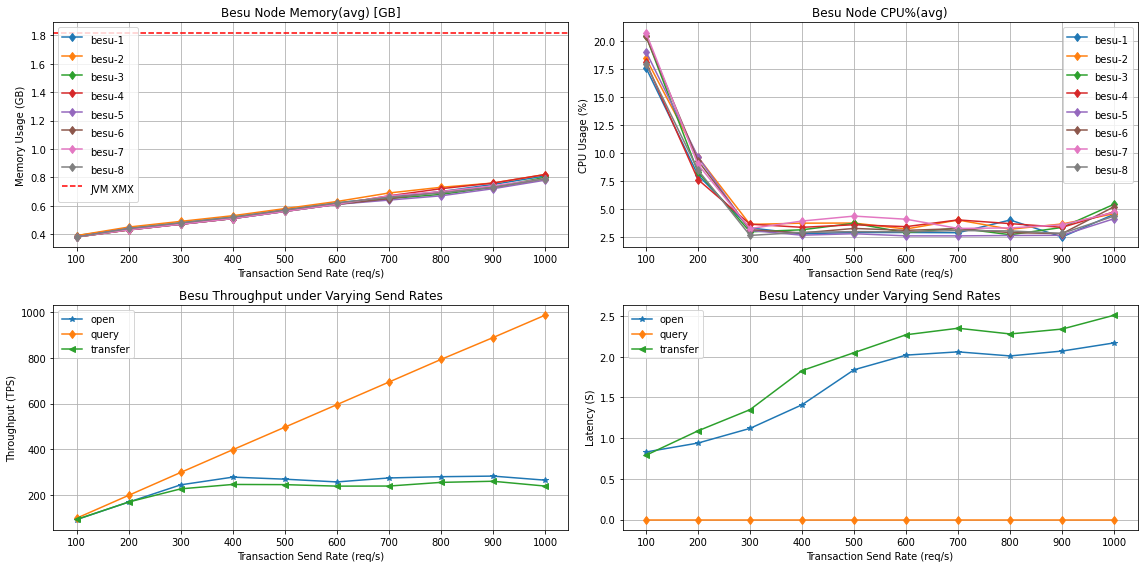

2C7.5G
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.


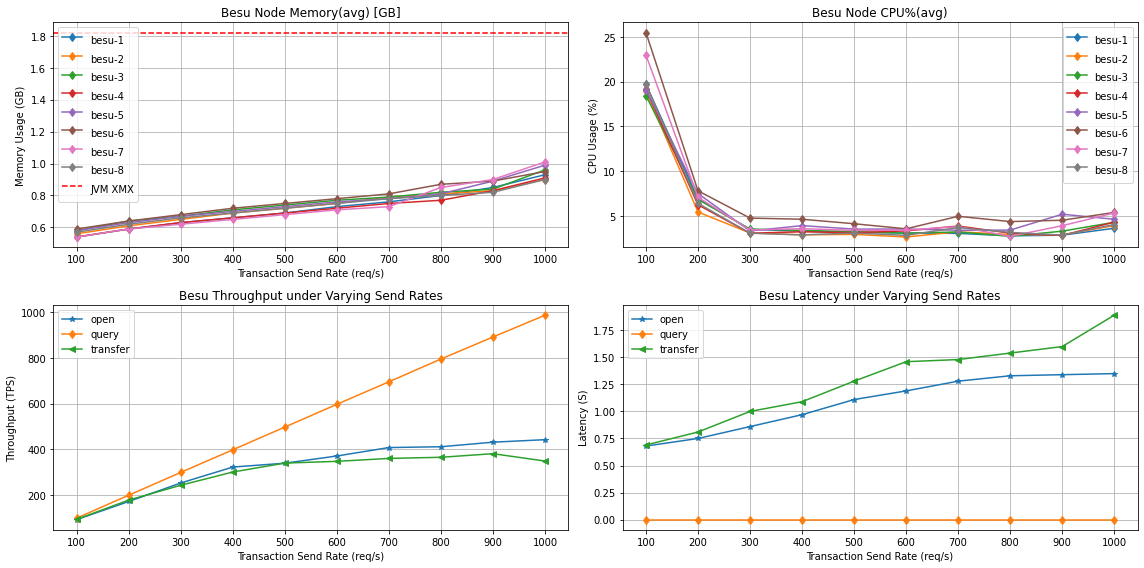

2C15G
20220415-190557 has 50 reports.
20220415-152109 has 50 reports.
20220415-161714 has 50 reports.
20220415-171354 has 50 reports.
20220415-181014 has 50 reports.


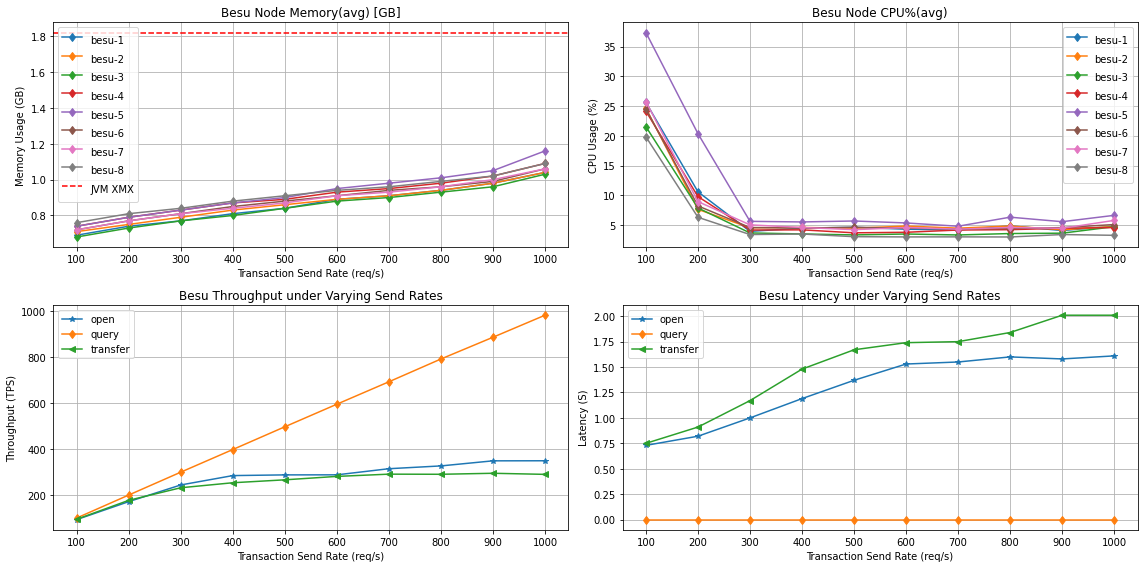

4C15G
20220414-072413 has 50 reports.
20220414-044206 has 50 reports.
20220414-053605 has 50 reports.
20220414-081809 has 50 reports.
20220414-063006 has 50 reports.


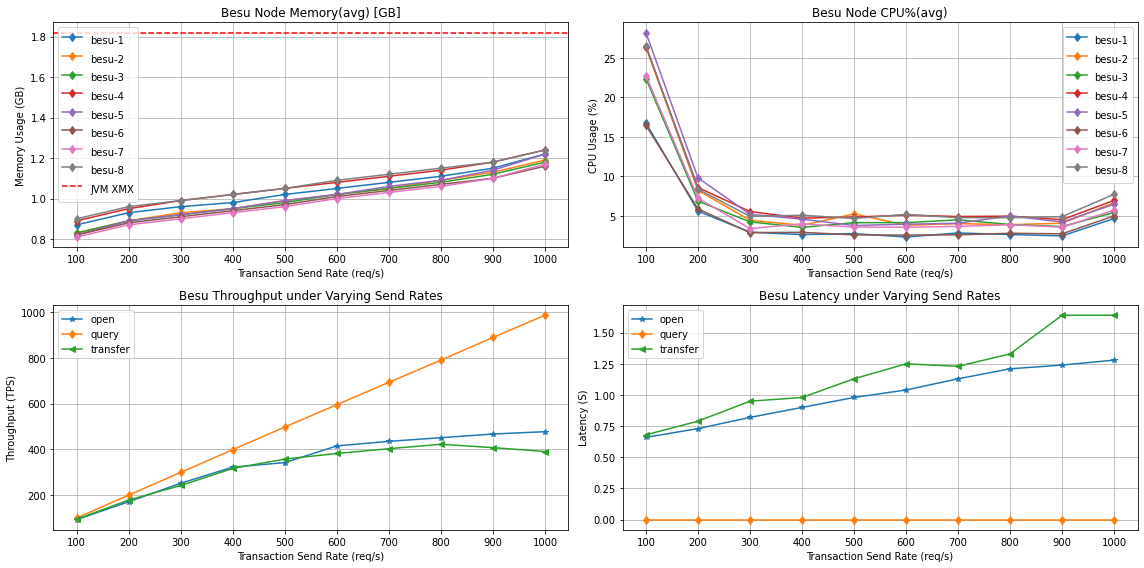

4C30G
20220415-132547 has 50 reports.
20220415-113806 has 50 reports.
20220415-104402 has 50 reports.
20220415-141952 has 50 reports.
20220415-123154 has 50 reports.


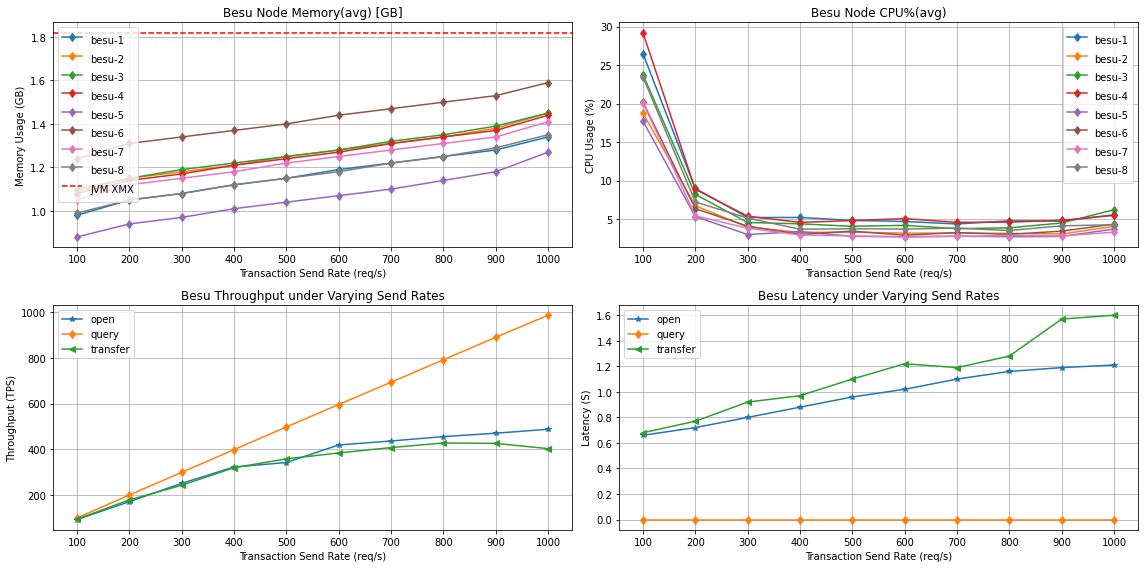

8C30G
20220415-075710 has 50 reports.
20220415-094444 has 50 reports.
20220415-085050 has 50 reports.
20220415-043110 has 47 reports.
20220415-070321 has 50 reports.


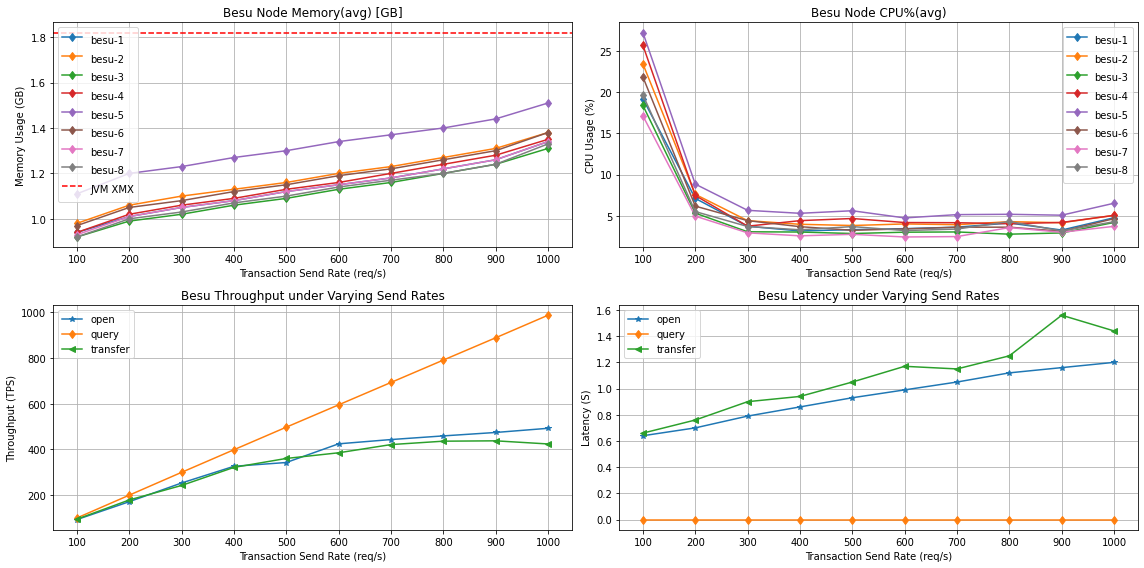

16C60G
20220414-161349 has 50 reports.
20220414-142558 has 50 reports.
20220414-151955 has 50 reports.
20220414-170738 has 50 reports.
20220414-180121 has 50 reports.


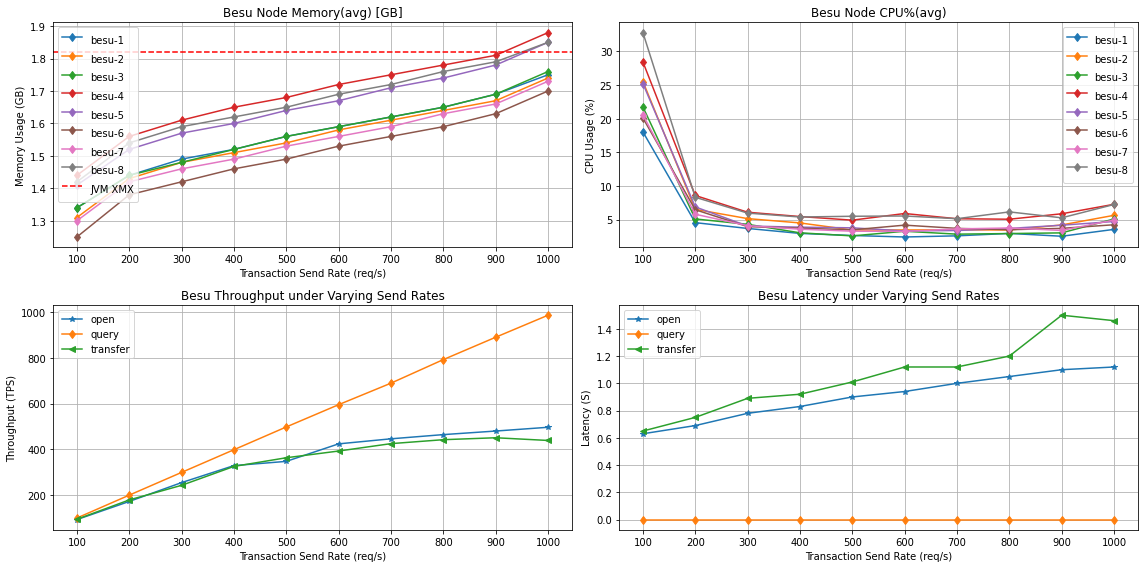

In [199]:
for fl in flavors:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_{}_QBFT_1S'.format(fl)
    print(fl)
    plot(reports_path)

# Baseline

In [471]:
reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S'
df_perf, df_res = get_res_df_multi_rounds(reports_path)
df = cal_mean(df_perf)

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!


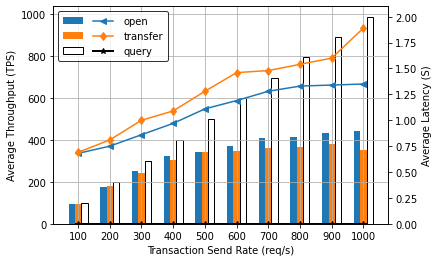

In [472]:
# df_res_mean = cal_mean(df_res)
# df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]
roundLabels = ['open', 'transfer', 'query']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']

data = []
for metric in metricLabels:
    values = []
    for index in roundLabels:
        res = df[df.index == index][metric].values
        values.append(res)
    data.append(values)

rates = df[df.index == roundLabels[0]]['Rate'].values.astype(int)
width = 0.2
X_axis = np.arange(1, len(rates)+1)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(X_axis - width, data[0][0], width=width, label='open', color='C0')
ax1.bar(X_axis, data[0][1], width=width, label='transfer', color='C1')
ax1.bar(X_axis + width, data[0][2], width=width, label='query', color='w', edgecolor='k')
ax1.set(ylabel='Average Throughput (TPS)')
ax1.set_xlabel('Transaction Send Rate (req/s)')
ax1.grid()

ax2 = ax1.twinx()

ax2.plot(X_axis, data[1][0], label='open', marker='<', color='C0')
ax2.plot(X_axis, data[1][1], label='transfer', marker='d', color='C1')
ax2.plot(X_axis, data[1][2], label='query', marker='*', color='k', linewidth=2)
ax2.set(ylabel='Average Latency (S)')
ax2.set_ylim(0, 2.1)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Create custom legend by unpacking tuples containing handles and using 
# only one set of unpacked labels along with set of unpacked empty strings
# (using None instead of empty strings gives the same result)
ax1.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
             loc='upper left', ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)
plt.xticks(X_axis, rates)
plt.show()

fig.set_size_inches(6,4)
fig.savefig('baseline.png', dpi=300)

In [12]:
def plot_baseline_perf(df_perf, y2lim=None):
    
    open_lat, open_tps = [], []
    transfer_lat, transfer_tps = [], []
    query_lat, query_tps = [], []
    rates = sorted(df_perf.Rate.unique().astype(int))
    for rate in rates:
        df = df_perf[(df_perf.Name=='open') & (df_perf.Rate==rate)]
        open_lat.append(df['Avg Latency (s)'].values)
        open_tps.append(df['Throughput (TPS)'].values)
        df = df_perf[(df_perf.Name=='transfer') & (df_perf.Rate==rate)]
        transfer_lat.append(df['Avg Latency (s)'].values)
        transfer_tps.append(df['Throughput (TPS)'].values)
        df = df_perf[(df_perf.Name=='query') & (df_perf.Rate==rate)]
        query_lat.append(df['Avg Latency (s)'].values)
        query_tps.append(df['Throughput (TPS)'].values)

    open_tps_mean = [np.mean(tps) for tps in open_tps]
    open_lat_mean = [np.mean(lat) for lat in open_lat]

    transfer_tps_mean = [np.mean(tps) for tps in transfer_tps]
    transfer_lat_mean = [np.mean(lat) for lat in transfer_lat]

    query_tps_mean = [np.mean(tps) for tps in query_tps]
    query_lat_mean = [np.mean(lat) for lat in query_lat]

    fig, ax1 = plt.subplots(figsize=(6, 4))
    X_axis = np.arange(1, len(rates)+1)
    showfliers=False
    showmeans=False
    patch_artist=True

    positions = np.arange(1, len(rates)+1)
    width = 0.2
    widths = tuple([0.2] * len(rates))

    ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"),widths=widths)
    ax1.plot(positions-width, open_tps_mean, color='C0', marker='<', label='open')
    ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"),widths=widths)
    ax1.plot(positions, transfer_tps_mean, color='C1', marker='d', label='transfer')
    ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C2"),widths=widths)
    ax1.plot(positions+width, query_tps_mean, color='C2', marker='*', label='query')

    ax1.grid()

    ax1.set_ylim(0, 1000)
    ax1.set_xlabel('Transaction send rate (req/s)')
    ax1.set_ylabel('Average Throughput (TPS)')

    ax2 = ax1.twinx()
    ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"),widths=widths)
    ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='<', label='open')
    ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"),widths=widths)
    ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='d', label='transfer')
    ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C2"),widths=widths)
    ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='*', label='query')
    ax2.set_xticks(X_axis)
    ax2.set_xticklabels(rates)
    if y2lim:
        ax2.set_ylim(0, y2lim)

    ax2.set_ylabel('Average Latency (s)')
    # ax2.set_xlabel('Send rate')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Create custom legend by unpacking tuples containing handles and using 
    # only one set of unpacked labels along with set of unpacked empty strings
    # (using None instead of empty strings gives the same result)
    ax1.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
                loc='upper left', ncol=2, handlelength=2, edgecolor='black',
                borderpad=0.5, handletextpad=1, columnspacing=0)

    plt.tight_layout()
    plt.show()
    return fig

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!


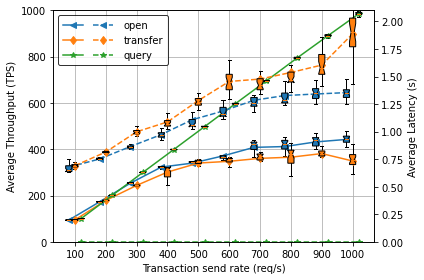

In [5]:
reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S'
df_perf, df_res = get_res_df_multi_rounds(reports_path, 2.1)
fig = plot_baseline_perf(df_perf)
# fig.set_size_inches(6,4)
# fig.savefig('baseline-bp.png', dpi=300)

20220421-222310 has 50 reports.
20220421-212903 has 50 reports.
20220421-194057 has 50 reports.
20220421-203503 has 50 reports.
20220421-184628 has 50 reports.
5 rounds of reports are collected!


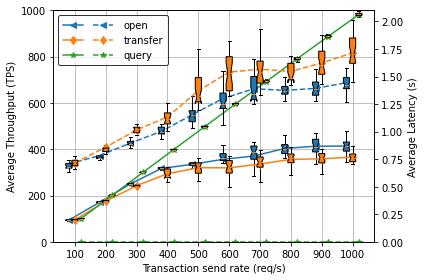

In [10]:
reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C15G_QBFT_1S'
df_perf, df_res = get_res_df_multi_rounds(reports_path)
fig = plot_baseline_perf(df_perf)
# fig.set_size_inches(6,4)
# fig.savefig('baseline-bp.png', dpi=300)

20220414-072413 has 50 reports.
20220414-044206 has 50 reports.
20220414-053605 has 50 reports.
20220414-081809 has 50 reports.
20220414-063006 has 50 reports.
5 rounds of reports are collected!


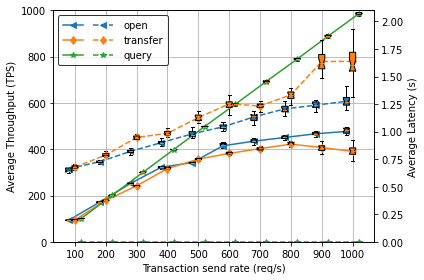

In [6]:
reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_4C15G_QBFT_1S'
df_perf, df_res = get_res_df_multi_rounds(reports_path)
fig = plot_baseline_perf(df_perf)
# fig.set_size_inches(6,4)
# fig.savefig('baseline-bp.png', dpi=300)

20220414-161349 has 50 reports.
20220414-142558 has 50 reports.
20220414-151955 has 50 reports.
20220414-170738 has 50 reports.
20220414-180121 has 50 reports.
5 rounds of reports are collected!


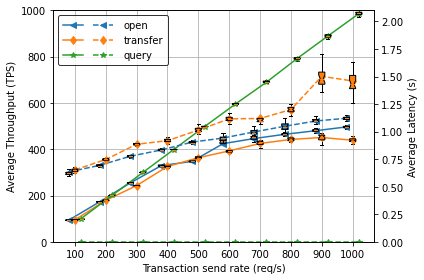

In [9]:
reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_16C60G_QBFT_1S'
df_perf, df_res = get_res_df_multi_rounds(reports_path)
fig = plot_baseline_perf(df_perf)

# Consensus

In [546]:
consensus = ['QBFT', 'IBFT2', 'CLIQUE']
metrics = ['Throughput (TPS)', 'Avg Latency (s)']
tx_types = ['open', 'transfer', 'query']
send_rates = np.arange(100, 110, 100)

df_perf_ls = []
df_res_ls = []
   
for c in consensus:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_{}_2S'.format(c)
    df_perf, df_res = get_res_df_multi_rounds(reports_path)

    df_perf_ls.append(df_perf)

    df_res.set_index('Name', inplace=True)
    df_res.index = [index.split('/')[1] for index in df_res.index]
    
    df_res_ls.append(df_res)

20220418-065115 has 50 reports.
20220418-074717 has 50 reports.
20220418-045841 has 50 reports.
20220418-040237 has 50 reports.
20220418-055441 has 50 reports.
5 rounds of reports are collected!
20220427-082753 has 50 reports.
20220427-151750 has 50 reports.
20220426-205611 has 50 reports.
20220427-112326 has 50 reports.
20220427-171428 has 50 reports.
20220427-033607 has 50 reports.
20220427-043427 has 50 reports.
20220427-072939 has 50 reports.
20220426-224831 has 50 reports.
20220427-053301 has 50 reports.
20220427-191129 has 38 reports.
20220427-092634 has 50 reports.
20220427-181311 has 50 reports.
20220427-141905 has 50 reports.
20220427-014106 has 50 reports.
20220427-122200 has 50 reports.
20220427-023834 has 50 reports.
20220426-195951 has 50 reports.
20220426-215227 has 50 reports.
20220427-161611 has 50 reports.
20220426-234548 has 50 reports.
20220427-102448 has 50 reports.
20220427-132023 has 50 reports.
20220427-063132 has 50 reports.
20220427-004319 has 50 reports.
3 rou

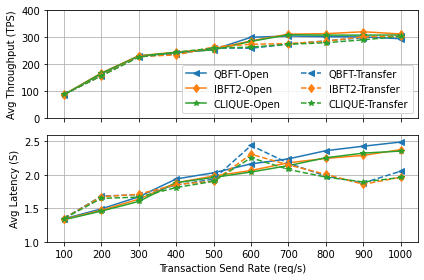

In [560]:
open_tps, open_lat = [], []
transfer_tps, transfer_lat = [], []
query_tps, query_lat = [], []

for i in range(len(consensus)):
    df_curr = df_perf_ls[i]
    
    df = df_curr[df_curr.Name=='open'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    open_lat.append(list(df['Avg Latency (s)'].values))
    open_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='transfer'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    transfer_lat.append(list(df['Avg Latency (s)'].values))
    transfer_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='query'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    query_lat.append(list(df['Avg Latency (s)'].values))
    query_tps.append(list(df['Throughput (TPS)'].values))

rates = np.arange(100, 1100, 100)
width = 0.2
X_axis = np.arange(1, len(rates)+1)

fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1, sharex=True)

axes[0].plot(X_axis, open_tps[0], marker='<',label='QBFT-Open', color='C0')
axes[0].plot(X_axis, open_tps[1], marker='d',label='IBFT2-Open', color='C1')
axes[0].plot(X_axis, open_tps[2], marker='*',label='CLIQUE-Open', color='C2')

axes[0].plot(X_axis, transfer_tps[0], '--', marker='<', label='QBFT-Transfer', color='C0')
axes[0].plot(X_axis, transfer_tps[1], '--', marker='d', label='IBFT2-Transfer', color='C1')
axes[0].plot(X_axis, transfer_tps[2], '--', marker='*', label='CLIQUE-Transfer', color='C2')

axes[0].set(ylabel='Avg Throughput (TPS)')
# axes[0].set_xlabel('Transaction Send Rate (req/s)')
axes[0].set_ylim(0, 400)
axes[0].grid()
axes[0].legend(ncol=2, loc='lower right')


# ax3 = axes[1].twinx()
axes[1].plot(X_axis, open_lat[0], label='QBFT', marker='<', color='C0')
axes[1].plot(X_axis, open_lat[1], label='IBFT2', marker='d', color='C1')
axes[1].plot(X_axis, open_lat[2], label='CLIQUE', marker='*', color='C2')

axes[1].plot(X_axis, transfer_lat[0], label='QBFT', linestyle='--', marker='<', color='C0')
axes[1].plot(X_axis, transfer_lat[1], label='IBFT2', linestyle='--', marker='d', color='C1')
axes[1].plot(X_axis, transfer_lat[2], label='CLIQUE', linestyle='--', marker='*', color='C2')
axes[1].set_ylim(1, 2.6)
axes[1].set_ylabel('Avg Latency (S)')
axes[1].set_xlabel('Transaction Send Rate (req/s)')
axes[1].grid()

axes[1].set_xticks(X_axis)
axes[1].set_xticklabels(rates)
plt.tight_layout()
plt.show()

# fig.set_size_inches(6, 4)
# fig.savefig('consensus.png', dpi=300)

In [372]:
consensus = ['QBFT', 'IBFT2', 'CLIQUE']
metrics = ['Avg Latency (s)', 'Throughput (TPS)']
tx_types = ['open', 'transfer', 'query']
send_rate = 1000
df_perf_ls = []
df_res_ls = []
for c in consensus:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_{}_1S'.format(c)
    df_perf, df_res = get_res_df_multi_rounds(reports_path)
    
    df_perf = df_perf[df_perf.Rate == send_rate]
    df_perf_ls.append(df_perf)
    
    df_res = df_res[df_res.Rate == send_rate]
    df_res.set_index('Name', inplace=True)
    df_res.index = [index.split('/')[1] for index in df_res.index]
    df_res_ls.append(df_res)
    
open_tps, open_lat = [], []
transfer_tps, transfer_lat = [], []
query_tps, query_lat = [], []

for i in range(len(consensus)):
    df_curr = df_perf_ls[i]
    
    df = df_curr[df_curr.Name=='open']

    open_lat.append(list(df['Avg Latency (s)'].values))
    open_tps.append(list(df['Throughput (TPS)'].values))
    df = df_curr[df_curr.Name=='transfer']
    transfer_lat.append(list(df['Avg Latency (s)'].values))
    transfer_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='query']
    query_lat.append(list(df['Avg Latency (s)'].values))
    query_tps.append(list(df['Throughput (TPS)'].values))

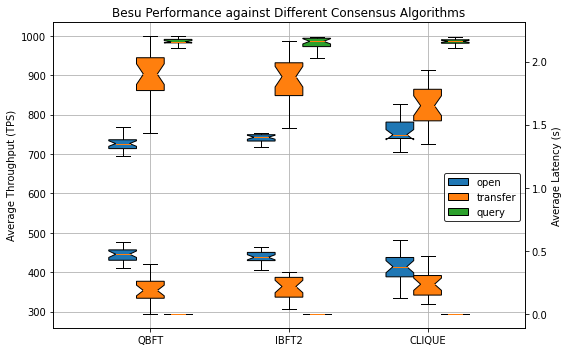

In [378]:
fig, ax1 = plt.subplots(figsize=(8, 5))
bals = ['LB Throughput', 'NLB Throughput', 'LB Latency', 'NLB Latency']
showfliers = False
showmeans = False
patch_artist = True
xlabels = consensus
positions = np.arange(1, len(consensus)+1)
width = 0.2
widths = tuple([0.2] * len(positions))

bp1 = ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans,  patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
bp2 = ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"), widths=widths)
bp3 = ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C2"), widths=widths)
ax1.grid()

ax1.set_title("Besu Performance against Different Consensus Algorithms")
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"), widths=widths)
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="C2"), showmeans=showmeans)
ax2.set_ylabel('Average Latency (s)')
ax2.set_xticks(positions)
ax2.set_xticklabels(consensus)

ax1.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['open', 'transfer', 'query'], loc=(0.83,0.35), edgecolor='black')

plt.tight_layout()
plt.show()

In [432]:
import statistics as st

consensus = ['QBFT', 'IBFT2', 'CLIQUE']
metrics = ['Throughput (TPS)', 'Avg Latency (s)']
tx_types = ['open', 'transfer', 'query']
send_rates = np.arange(100, 110, 100)

df_perf_ls = []
df_res_ls = []
   
for c in consensus:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_{}_1S'.format(c)
    df_perf, df_res = get_res_df_multi_rounds(reports_path)

    df_perf_ls.append(df_perf)

    df_res.set_index('Name', inplace=True)
    df_res.index = [index.split('/')[1] for index in df_res.index]
    
    df_res_ls.append(df_res)

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220412-184937 has 50 reports.
20220412-175548 has 50 reports.
20220412-203728 has 50 reports.
20220412-170135 has 50 reports.
20220412-194330 has 50 reports.
5 rounds of reports are collected!
20220422-051843 has 50 reports.
20220422-061247 has 50 reports.
20220422-042430 has 50 reports.
20220422-033007 has 50 reports.
20220422-070657 has 50 reports.
5 rounds of reports are collected!


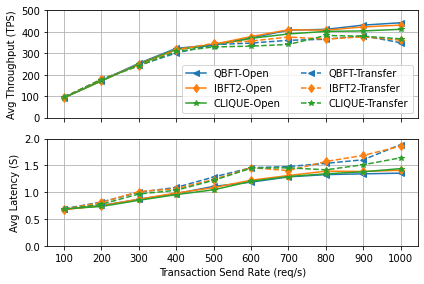

In [458]:
open_tps, open_lat = [], []
transfer_tps, transfer_lat = [], []
query_tps, query_lat = [], []

for i in range(len(consensus)):
    df_curr = df_perf_ls[i]
    
    df = df_curr[df_curr.Name=='open'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    open_lat.append(list(df['Avg Latency (s)'].values))
    open_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='transfer'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    transfer_lat.append(list(df['Avg Latency (s)'].values))
    transfer_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='query'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    query_lat.append(list(df['Avg Latency (s)'].values))
    query_tps.append(list(df['Throughput (TPS)'].values))

rates = np.arange(100, 1100, 100)
width = 0.2
X_axis = np.arange(1, len(rates)+1)

fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1, sharex=True)
# axes[0].bar(X_axis - width, open_tps[0], width=width, label='QBFT', color='C0')
# axes[0].bar(X_axis, open_tps[1], width=width, label='IBFT2', color='C1')
# axes[0].bar(X_axis + width, open_tps[2], width=width, label='CLIQUE', color='C2')
axes[0].plot(X_axis, open_tps[0], marker='<',label='QBFT-Open', color='C0')
axes[0].plot(X_axis, open_tps[1], marker='d',label='IBFT2-Open', color='C1')
axes[0].plot(X_axis, open_tps[2], marker='*',label='CLIQUE-Open', color='C2')

axes[0].plot(X_axis, transfer_tps[0], '--', marker='<', label='QBFT-Transfer', color='C0')
axes[0].plot(X_axis, transfer_tps[1], '--', marker='d', label='IBFT2-Transfer', color='C1')
axes[0].plot(X_axis, transfer_tps[2], '--', marker='*', label='CLIQUE-Transfer', color='C2', )

axes[0].set(ylabel='Avg Throughput (TPS)')
# axes[0].set_xlabel('Transaction Send Rate (req/s)')
axes[0].set_ylim(0, 500)
axes[0].grid()
axes[0].legend(ncol=2)


# ax3 = axes[1].twinx()
axes[1].plot(X_axis, open_lat[0], label='QBFT', marker='<', color='C0')
axes[1].plot(X_axis, open_lat[1], label='IBFT2', marker='d', color='C1')
axes[1].plot(X_axis, open_lat[2], label='CLIQUE', marker='*', color='C2')

axes[1].plot(X_axis, transfer_lat[0], label='QBFT', linestyle='--', marker='<', color='C0')
axes[1].plot(X_axis, transfer_lat[1], label='IBFT2', linestyle='--', marker='d', color='C1')
axes[1].plot(X_axis, transfer_lat[2], label='CLIQUE', linestyle='--', marker='*', color='C2')
axes[1].set_ylim(0, 2.)
axes[1].set_ylabel('Avg Latency (S)')
axes[1].set_xlabel('Transaction Send Rate (req/s)')
axes[1].grid()

axes[1].set_xticks(X_axis)
axes[1].set_xticklabels(rates)
plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('consensus.png', dpi=300)

QBFT
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!


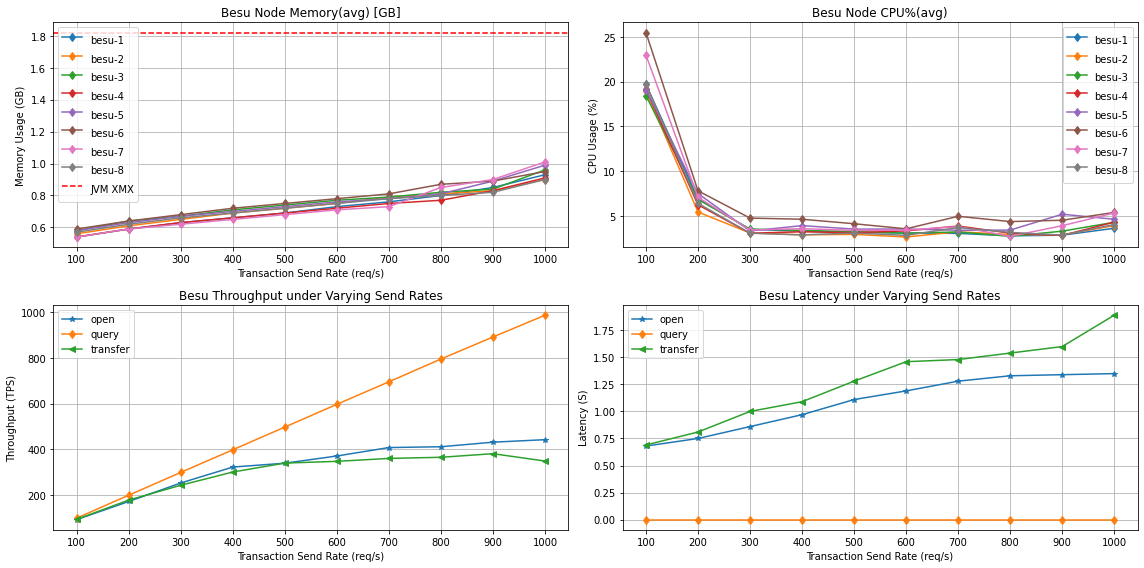

IBFT2
20220412-184937 has 50 reports.
20220412-175548 has 50 reports.
20220412-203728 has 50 reports.
20220412-170135 has 50 reports.
20220412-194330 has 50 reports.
5 rounds of reports are collected!


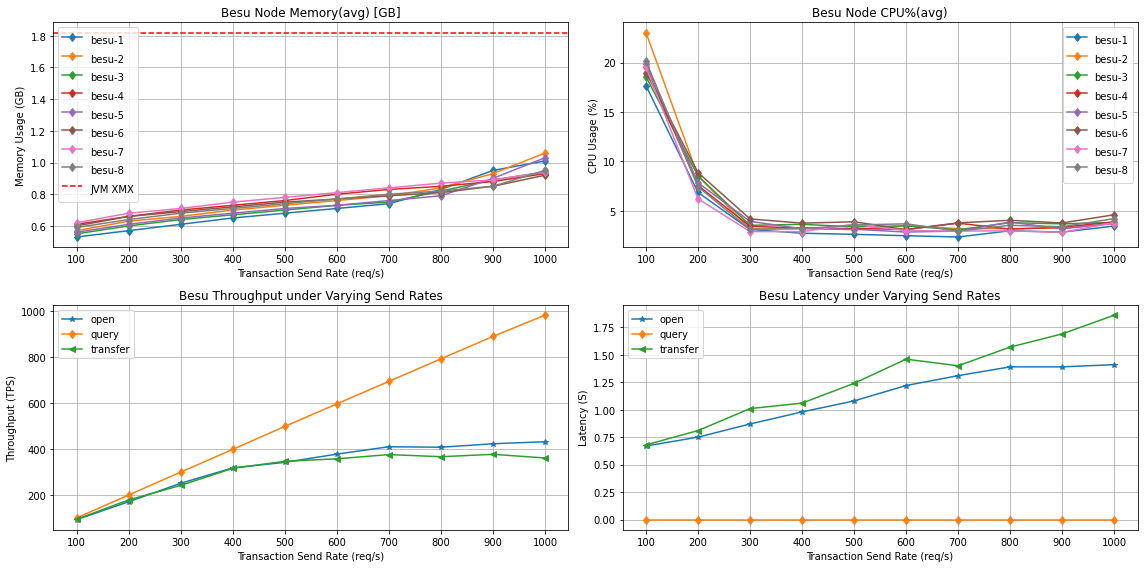

CLIQUE
20220422-051843 has 50 reports.
20220422-151500 has 21 reports.
20220422-142050 has 50 reports.
20220422-061247 has 50 reports.
20220422-042430 has 50 reports.
20220422-094956 has 50 reports.
20220422-113810 has 50 reports.
20220422-132649 has 50 reports.
20220422-123227 has 50 reports.
20220422-104347 has 50 reports.
20220422-080115 has 50 reports.
20220422-033007 has 50 reports.
20220422-070657 has 50 reports.
20220422-085539 has 50 reports.
14 rounds of reports are collected!


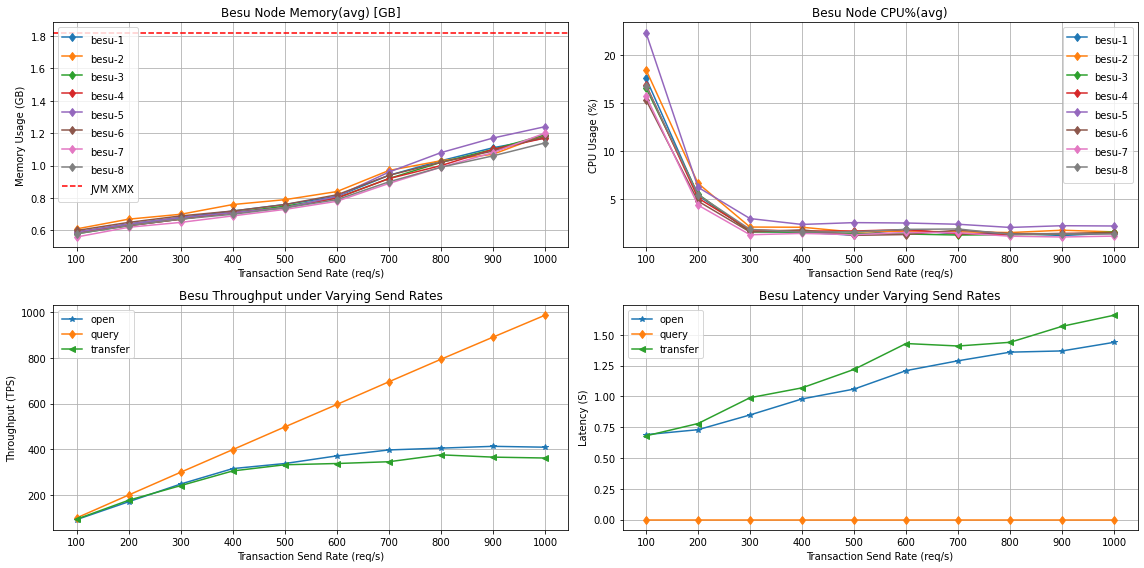

In [355]:
for c in consensus:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_{}_1S'.format(c)
    print(c)
    plot(reports_path)

# Balance vs non-balance

20220412-021244 has 50 reports.
20220412-031423 has 50 reports.
20220412-041522 has 50 reports.
20220412-084301 has 50 reports.
20220412-051639 has 50 reports.
5 rounds of reports are collected!


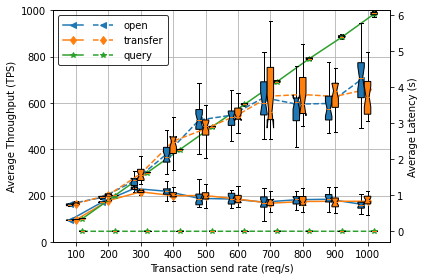

In [13]:
# reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_NLB_2C7.5G_QBFT_1S'
# df_perf, df_res = get_res_df_multi_rounds(reports_path)
# fig = plot_baseline_perf(df_perf)
fig.set_size_inches(6,4)
fig.savefig('nlb.png', dpi=300)

In [14]:
fig.set_size_inches(6,4)
fig.savefig('./figs/nlb.png', dpi=300)

In [15]:
_, df_res = get_res_df_multi_rounds(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')
df_res = df_res[df_res.Rate == 1000]
df_res.set_index('Name', inplace=True)
df_res.index = [index.split('/')[1] for index in df_res.index]

_, df_res_nlb = get_res_df_multi_rounds(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_NLB_2C7.5G_QBFT_1S')
df_res_nlb = df_res_nlb[df_res_nlb.Rate == 1000]
df_res_nlb.set_index('Name', inplace=True)
df_res_nlb.index = [index.split('/')[1] for index in df_res_nlb.index]

lb_cpu, lb_ram = [], []
nlb_cpu, nlb_ram = [], []
node_names = df_res.index.unique()
len_nodes = len(node_names)

for i in range(1, len_nodes+1):
    df = df_res[df_res.index == 'besu-{}'.format(i)]
    lb_cpu.append(list(df['CPU%(avg)'].values))
    lb_ram.append(list(df['Memory(avg) [GB]'].values))
    
    df_nlb = df_res_nlb[df_res_nlb.index == 'besu-{}'.format(i)]
    nlb_cpu.append(list(df_nlb['CPU%(avg)'].values))
    nlb_ram.append(list(df_nlb['Memory(avg) [GB]'].values))

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220412-021244 has 50 reports.
20220412-031423 has 50 reports.
20220412-041522 has 50 reports.
20220412-084301 has 50 reports.
20220412-051639 has 50 reports.
5 rounds of reports are collected!


In [20]:
df_res_nlb.index.name = 'node'
df_res_nlb.groupby(['node']).mean()

CPU%(max)  CPU%(avg)  Memory(max) [GB]  Memory(avg) [GB]  \
node                                                               
besu-1   162.0472    58.2392           2.39240           2.38840   
besu-2     5.5684     4.1584           0.87856           0.87796   
besu-3     4.4924     3.2432           0.85592           0.85516   
besu-4     3.5188     2.7792           0.92928           0.92884   
besu-5     5.4292     4.2344           0.84460           0.84380   
besu-6     4.2548     3.3852           0.85744           0.85664   
besu-7     3.4972     2.7556           0.85732           0.85660   
besu-8     4.0004     3.2120           0.84396           0.84328   

        Traffic In [B]  Traffic Out [B]  Disc Write [B]  Disc Read [B]  \
node                                                                     
besu-1             0.0              0.0             0.0            0.0   
besu-2             0.0              0.0             0.0            0.0   
besu-3             0.0              0.0             0.0            0.0   
besu-4             0.0              0.0             0.0            0.0   
besu-5             0.0              0.0             0.0            0.0   
besu-6             0.0              0.0             0.0            0.0   
besu-7             0.0              0.0             0.0            0.0   
besu-8             0.0              0.0             0.0            0.0   

          Rate  Disc Read [KB]  Disc Write [MB]  Disc Read [MB]  
node                                                             
besu-1  1000.0           158.0             49.7            26.7  
besu-2  1000.0             0.0              0.0             0.0  
besu-3  1000.0             0.0              0.0             0.0  
besu-4  1000.0             0.0              0.0             0.0  
besu-5  1000.0             0.0              0.0             0.0  
besu-6  1000.0             0.0              0.0             0.0  
besu-7  1000.0             0.0              0.0             0.0  
besu-8  1000.0             0.0              0.0             0.0

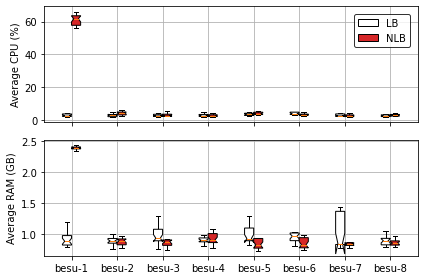

In [414]:
fig, axes = plt.subplots(figsize=(6, 4), nrows=2, ncols=1, sharex=True)
showfliers = False
showmeans = False
patch_artist = True
xlabels = list(node_names)
positions = np.arange(1, len(node_names)+1)
width = 0.2
widths = tuple([0.2] * len(node_names))

bp1 = axes[0].boxplot(lb_cpu, positions=positions-width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
bp2 = axes[0].boxplot(nlb_cpu, positions=positions+width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C3"), widths=widths)
axes[0].set_ylabel('Average CPU (%)')
axes[0].legend([bp1["boxes"][0], bp2["boxes"][0]], ['LB', 'NLB'], loc=(0.83,0.65), edgecolor='black')
axes[0].grid()

bp3 = axes[1].boxplot(lb_ram, positions=positions-width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
bp4 = axes[1].boxplot(nlb_ram, positions=positions+width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C3"), widths=widths)
axes[1].grid()

# axes[1].set_xlabel('Besu Nodes')
axes[1].set_ylabel('Average RAM (GB)')
# axes[1].legend([bp3["boxes"][0], bp4["boxes"][0]], ['LB RAM', 'NLB RAM'], loc=(0.88,0.75), edgecolor='black')
axes[1].set_xticks(positions)
axes[1].set_xticklabels(node_names)

plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('lb-res.png', dpi=300)

In [531]:
bals = ['LB', 'NLB']

roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

sendrate = 1000
for bal in bals:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_{}_2C7.5G_QBFT_1S'.format(bal)
    df, df_res = get_res_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]
    df_res = df_res[df_res.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220412-021244 has 50 reports.
20220412-031423 has 50 reports.
20220412-041522 has 50 reports.
20220412-084301 has 50 reports.
20220412-051639 has 50 reports.
5 rounds of reports are collected!


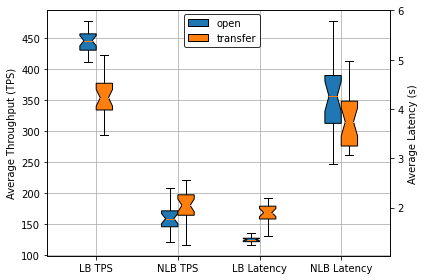

In [538]:
fig, ax1 = plt.subplots(figsize=(6, 4))
bals = ['LB TPS', 'NLB TPS', 'LB Latency', 'NLB Latency']
showfliers = False
showmeans = False
patch_artist = True
xlabels = bals
tpspos = np.arange(1, 3)
latpos = np.arange(3, 5)
positions = np.arange(1, len(bals)+1)
width = 0.2
widths = tuple([0.2] * len(tpspos))

bp1 = ax1.boxplot(open_tps, positions=tpspos-width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans,  patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
# ax1.plot(positions-width, open_tps_mean, color='C0', marker='*', label='open')
bp2 = ax1.boxplot(transfer_tps, positions=tpspos+width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"), widths=widths)
# ax1.plot(positions, transfer_tps_mean, color='C1', marker='<', label='transfer')
# bp3 = ax1.boxplot(query_tps, positions=tpspos+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C2"), widths=widths)
# ax1.plot(positions+width, query_tps_mean, color='C2', marker='d', label='query')
ax1.grid()

# ax1.set_title("Besu Performance (LB v.s. NLB)")
# ax1.set_xlabel('Network Size (Num of Validators)')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=latpos-width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
# ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=latpos+width/2, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C1"), widths=widths)
# ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='<', label='transfer')
# ax2.boxplot(query_lat, positions=latpos+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="C2"), showmeans=showmeans)
# ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])
ax2.set_xticks(positions)
ax2.set_xticklabels(bals)

ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['open', 'transfer'], loc=(0.4,0.85), edgecolor='black')

plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('lb-nlb.png', dpi=300)

LB
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.


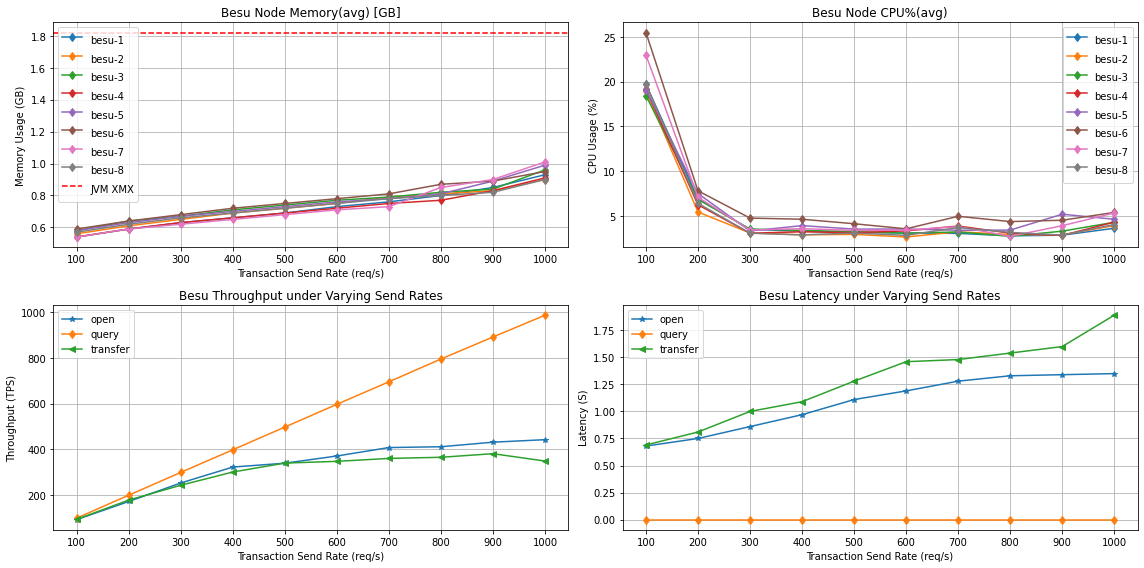

NLB
20220412-021244 has 50 reports.
20220412-031423 has 50 reports.
20220412-041522 has 50 reports.
20220412-084301 has 50 reports.
20220412-051639 has 50 reports.


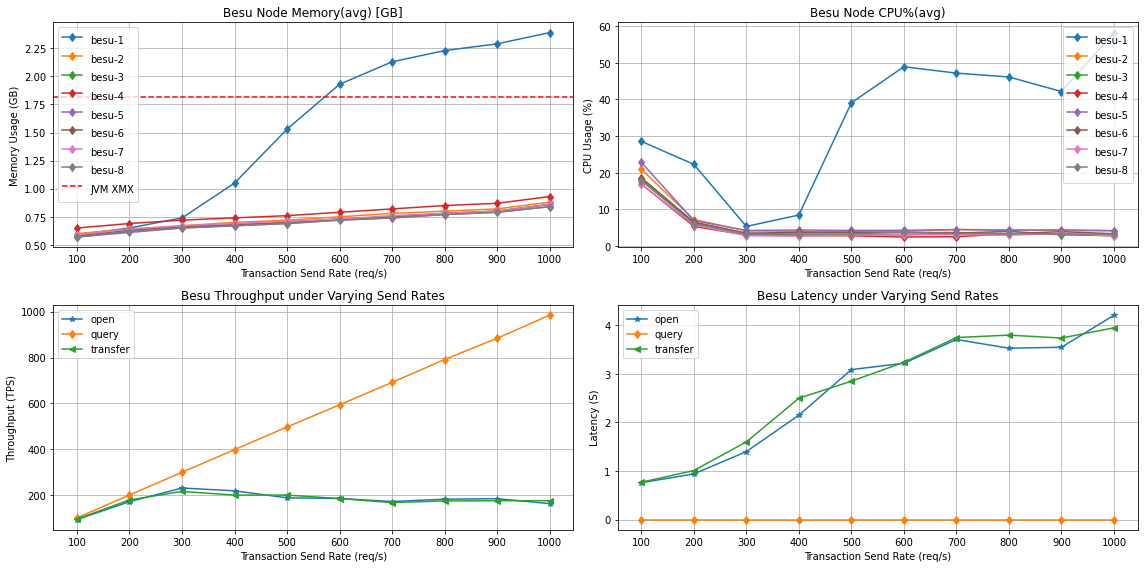

In [211]:
bals = ['LB', 'NLB']
for bal in bals:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_{}_2C7.5G_QBFT_1S'.format(bal)
    print(bal)
    plot(reports_path)

# Block Time

In [567]:
blocktimes = np.arange(1, 6)

roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

sendrate = 1000
for blt in blocktimes:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_{}S'.format(blt)
    if blt in [3,4]:
        reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_{}S_1000TPS'.format(blt)
    df, _ = get_res_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220418-065115 has 50 reports.
20220418-074717 has 50 reports.
20220418-045841 has 50 reports.
20220418-040237 has 50 reports.
20220418-055441 has 50 reports.
5 rounds of reports are collected!
20220427-202219 has 5 reports.
20220427-200458 has 5 reports.
20220427-203938 has 5 reports.
20220427-203052 has 5 reports.
20220427-201341 has 5 reports.
5 rounds of reports are collected!
20220428-012604 has 5 reports.
20220428-013456 has 5 reports.
20220428-020108 has 5 reports.
20220428-014338 has 5 reports.
20220428-015215 has 5 reports.
5 rounds of reports are collected!
20220420-200653 has 50 reports.
20220420-220925 has 50 reports.
20220420-180509 has 50 reports.
20220420-190559 has 50 reports.
20220420-210800 has 50 reports.
5 rounds of reports are collected!


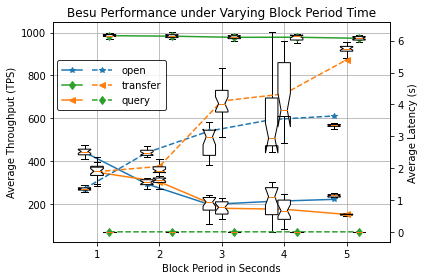

In [568]:
open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]

fig, ax1 = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
xlabels = blocktimes
positions = np.arange(1, len(blocktimes)+1)
width = 0.2
widths = tuple([0.2] * len(blocktimes))

ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax1.plot(positions-width, open_tps_mean, color='C0', marker='*', label='open')
ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax1.plot(positions+width, query_tps_mean, color='C2', marker='d', label='query')
ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax1.plot(positions, transfer_tps_mean, color='C1', marker='<', label='transfer')
# ax1.set_ylim(100, 1000)
ax1.grid()

ax1.set_title("Besu Performance under Varying Block Period Time")
ax1.set_xlabel('Block Period in Seconds')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='<', label='transfer')
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="w"), showmeans=showmeans)
ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.set_xticks(positions)
ax2.set_xticklabels(blocktimes)
# Create custom legend by unpacking tuples containing handles and using 
# only one set of unpacked labels along with set of unpacked empty strings
# (using None instead of empty strings gives the same result)
ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
             loc=(0.01,0.6), ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)
# ax2.set_ylim(0,6)
plt.tight_layout()
plt.show()

# fig.set_size_inches(6, 4)
# fig.savefig('blocktime.png', dpi=300)

In [539]:
blocktimes = np.arange(1, 6)

roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

sendrate = 1000
for blt in blocktimes:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_{}S'.format(blt)
    df, _ = get_res_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!
20220418-065115 has 50 reports.
20220418-074717 has 50 reports.
20220418-045841 has 50 reports.
20220418-040237 has 50 reports.
20220418-055441 has 50 reports.
5 rounds of reports are collected!
20220419-202605 has 50 reports.
20220419-222152 has 50 reports.
20220420-001753 has 50 reports.
20220419-231947 has 50 reports.
20220419-212402 has 50 reports.
5 rounds of reports are collected!
20220421-023801 has 50 reports.
20220421-033726 has 50 reports.
20220421-063529 has 50 reports.
20220421-043633 has 50 reports.
20220421-053549 has 50 reports.
5 rounds of reports are collected!
20220420-200653 has 50 reports.
20220420-220925 has 50 reports.
20220420-180509 has 50 reports.
20220420-190559 has 50 reports.
20220420-210800 has 50 reports.
5 rounds of reports are collected!


In [526]:
open_lat

[array([1.42, 1.39, 1.31, 1.4 , 1.48, 1.28, 1.38, 1.25, 1.37, 1.45, 1.37,
        1.31, 1.31, 1.35, 1.47, 1.34, 1.35, 1.31, 1.3 , 1.3 , 1.36, 1.3 ,
        1.35, 1.35, 1.35]),
 array([2.4 , 2.4 , 2.56, 2.46, 2.45, 2.39, 2.57, 2.62, 2.42, 2.68, 2.4 ,
        2.53, 2.55, 2.46, 2.46, 2.36, 2.6 , 2.52, 2.37, 2.41, 2.7 , 2.56,
        2.48, 2.34, 2.5 ]),
 array([3.06, 2.04, 2.51, 1.92, 2.11, 1.95, 1.84, 1.88, 1.91, 2.04, 1.79,
        1.9 , 2.17, 1.89, 1.92, 1.93, 1.93, 1.98, 1.91, 2.11, 1.8 , 1.83,
        1.89, 1.92, 2.05]),
 array([2.33, 2.52, 2.41, 2.45, 2.5 , 2.49, 2.42, 2.48, 2.38, 2.38, 2.51,
        2.51, 2.32, 2.51, 2.41, 2.58, 2.41, 2.44, 2.39, 2.36, 2.41, 2.26,
        2.45, 3.99, 2.39]),
 array([5.02, 3.31, 3.31, 3.31, 3.24, 3.34, 3.2 , 3.25, 3.36, 3.23, 3.34,
        3.29, 3.33, 3.32, 3.37, 3.43, 5.92, 3.36, 3.49, 4.79, 3.27, 3.32,
        3.35, 3.34, 5.41])]

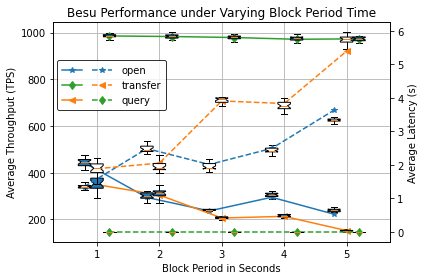

In [545]:
open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]

fig, ax1 = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
xlabels = blocktimes
positions = np.arange(1, len(blocktimes)+1)
width = 0.2
widths = tuple([0.2] * len(blocktimes))

ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions-width, open_tps_mean, color='C0', marker='*', label='open')
ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions+width, query_tps_mean, color='C2', marker='d', label='query')
ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="C0"), widths=widths)
ax1.plot(positions, transfer_tps_mean, color='C1', marker='<', label='transfer')
# ax1.set_ylim(100, 1000)
ax1.grid()

ax1.set_title("Besu Performance under Varying Block Period Time")
ax1.set_xlabel('Block Period in Seconds')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions-width, open_lat_mean, '--', color='C0', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="w"), widths=widths)
ax2.plot(positions, transfer_lat_mean, '--', color='C1', marker='<', label='transfer')
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="w"), showmeans=showmeans)
ax2.plot(positions+width, query_lat_mean, '--', color='C2', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.set_xticks(positions)
ax2.set_xticklabels(blocktimes)
# Create custom legend by unpacking tuples containing handles and using 
# only one set of unpacked labels along with set of unpacked empty strings
# (using None instead of empty strings gives the same result)
ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
             loc=(0.01,0.6), ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)
# ax2.set_ylim(0,6)
plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('blocktime.png', dpi=300)

Blocktime:  1 s
20220415-033229 has 50 reports.
20220415-004907 has 50 reports.
20220415-023758 has 50 reports.
20220414-235434 has 50 reports.
20220415-014336 has 50 reports.
5 rounds of reports are collected!


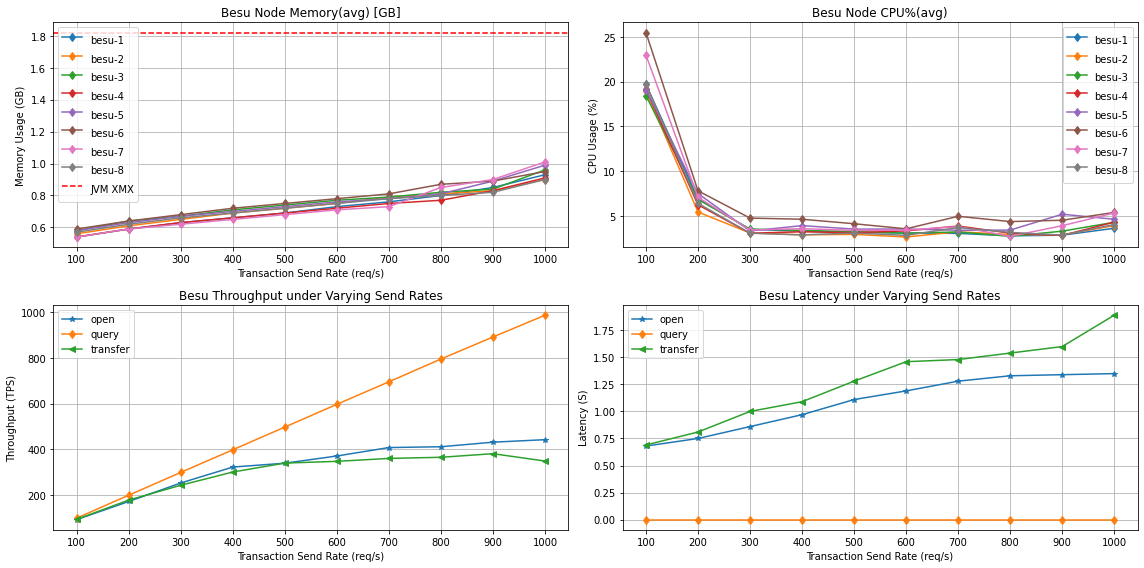

Blocktime:  2 s
20220418-065115 has 50 reports.
20220418-074717 has 50 reports.
20220418-045841 has 50 reports.
20220418-040237 has 50 reports.
20220418-055441 has 50 reports.
5 rounds of reports are collected!


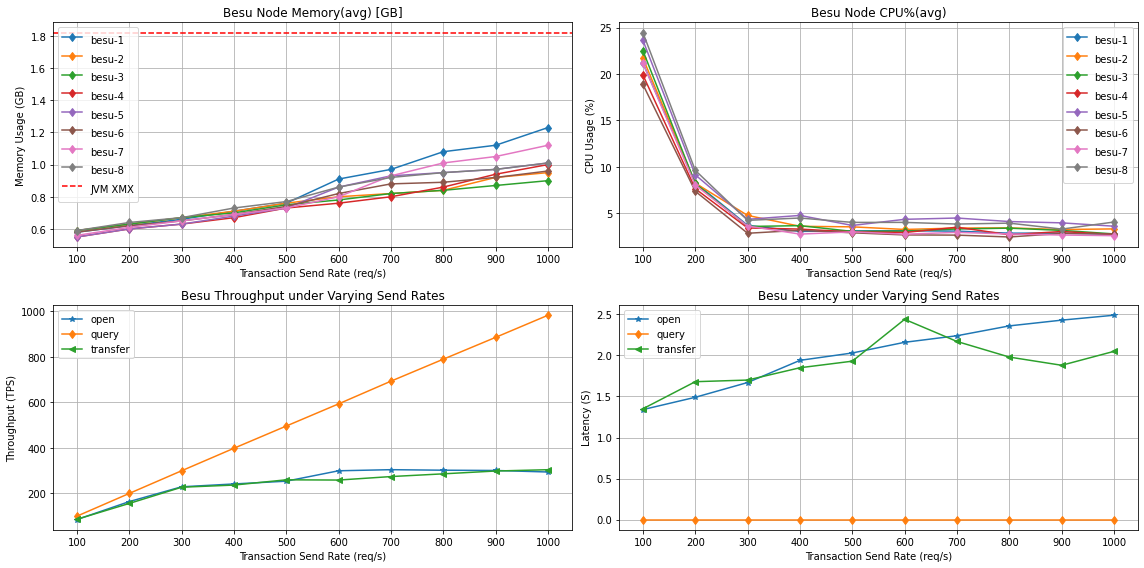

Blocktime:  3 s
20220419-202605 has 50 reports.
20220419-222152 has 50 reports.
20220420-001753 has 50 reports.
20220419-231947 has 50 reports.
20220419-212402 has 50 reports.
5 rounds of reports are collected!


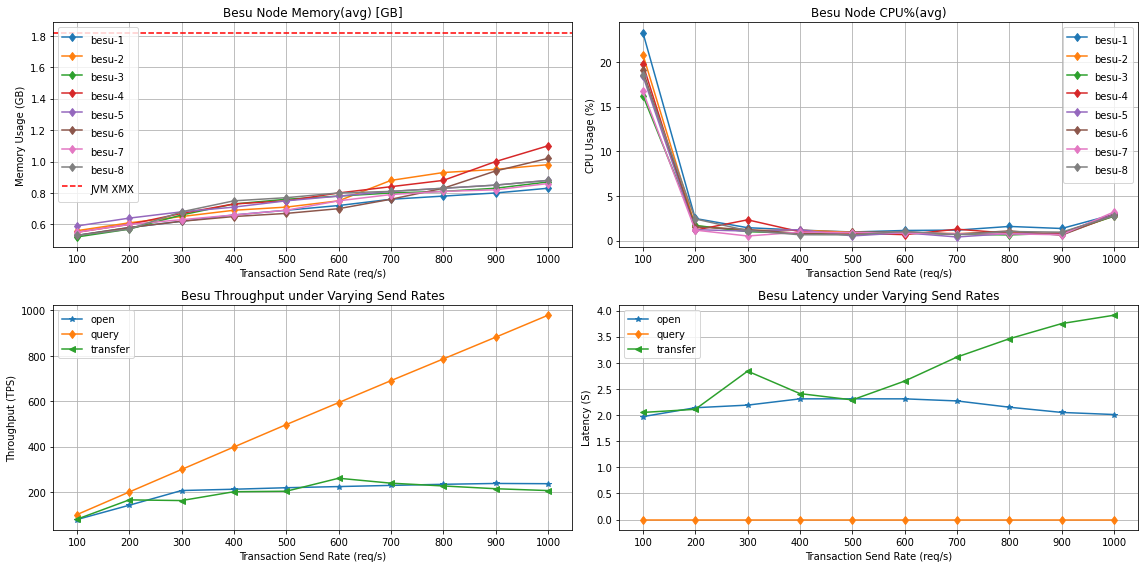

Blocktime:  4 s
20220421-023801 has 50 reports.
20220421-033726 has 50 reports.
20220421-063529 has 50 reports.
20220421-043633 has 50 reports.
20220421-053549 has 50 reports.
5 rounds of reports are collected!


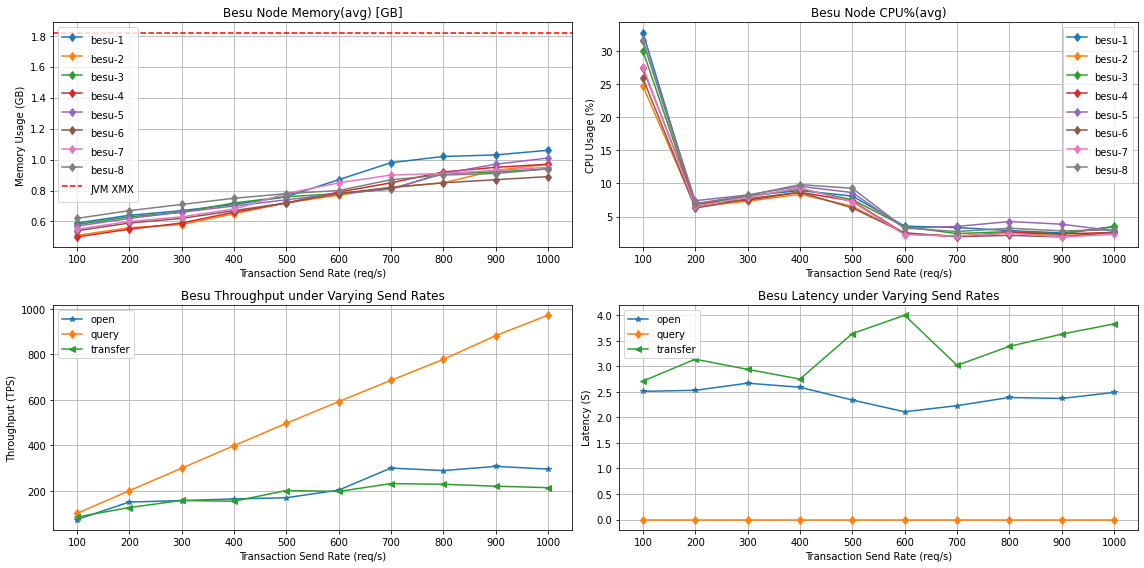

Blocktime:  5 s
20220420-200653 has 50 reports.
20220420-220925 has 50 reports.
20220420-180509 has 50 reports.
20220420-190559 has 50 reports.
20220420-210800 has 50 reports.
5 rounds of reports are collected!


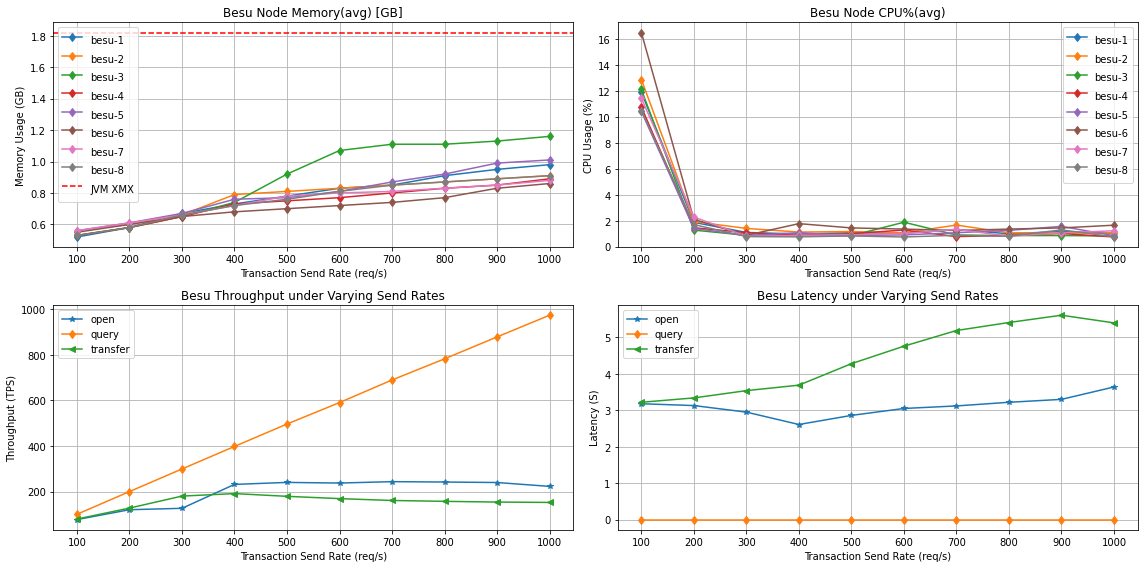

In [530]:
blocktimes = np.arange(1, 6)
for blt in blocktimes:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_{}S'.format(blt)
    print('Blocktime: ', blt, 's')
    plot(reports_path)